In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tabulate import tabulate
from matplotlib.colors import LogNorm
import textwrap
from collections import Counter
import re



# Specify the file path
file_path = r"cleaned_target_drugs.csv"
data_dictionary = r"faers_analysis_dataset_dictionary.xlsx"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_dictionary = pd.read_excel(data_dictionary, sheet_name=None)
for sheet_name, drug in df_dictionary.items():
    # Perform your processing here
    print(f"Sheet name: {sheet_name}")

#Get the sheet named Psychiatric Disorder Reac Grp from df_dictionary
df_faers_data_dictionary = df_dictionary['faers_2004_2024q1_dictionary']
df_target_drugs = df_dictionary['Target Drugs']
df_psychiatric = df_dictionary['Psychiatric Disorder Reac Grp']


Sheet name: faers_2004_2024q1_dictionary
Sheet name: Target Drugs
Sheet name: Psychiatric Disorder Reac Grp


Descriptive statistics table

In [47]:
df.describe()

,caseid,age,is_p,days_since_approval,years_since_approval,got_warning
count,8.091400e+04,80914.000000,80914.000000,80914.000000,80914.000000,80914.000000
mean,1.433434e+07,45.319584,0.763391,7617.414452,20.874360,0.285488
std,4.942017e+06,25.580197,0.425003,1864.685525,5.104953,0.451649
min,3.242728e+06,0.000000,0.000000,45.000000,0.000000,0.000000
25%,1.024389e+07,24.000000,1.000000,6788.250000,19.000000,0.000000
50%,1.398683e+07,48.000000,1.000000,7918.000000,22.000000,0.000000
75%,1.834424e+07,66.000000,1.000000,8979.000000,25.000000,1.000000
max,2.368980e+07,110.000000,1.000000,11311.000000,31.000000,1.000000


In [48]:
#Remove the warnings
pd.options.mode.chained_assignment = None

#In target drug sheet, change Singulaira to Singulair in brand name column
df_target_drugs['Brand Name'] = df_target_drugs['Brand Name'].str.replace('Singulaira', 'Singulair')
#Remove rows from Brand Name column that contain NaN
df_target_drugs = df_target_drugs.dropna(subset=['Brand Name'])
df_target_drugs['Brand Name'] = df_target_drugs['Brand Name'].str.lower()
print(df_target_drugs['Brand Name'].unique())

['singulair' 'accolate' 'zyflo' 'xyzal' 'zyrtec' 'allegra' 'claritin']


['YR']


Text(0.5, 1.0, 'Age Distribution')

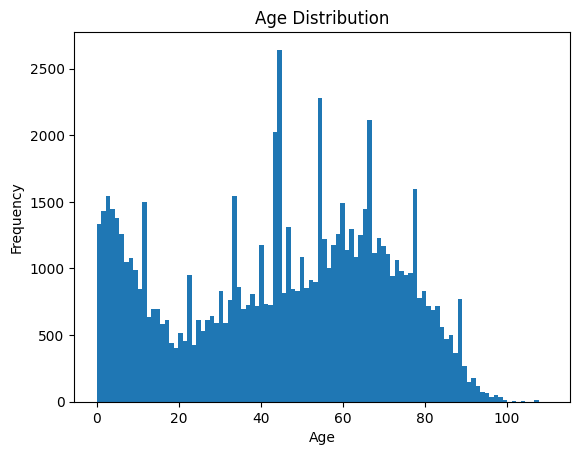

In [49]:
#Find the age codes in the column
print(df['age_cod'].unique())


df['age'].plot(kind='hist', bins=100)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

Here is the number of null values: 0
Here is the units of the age column: ['YR']


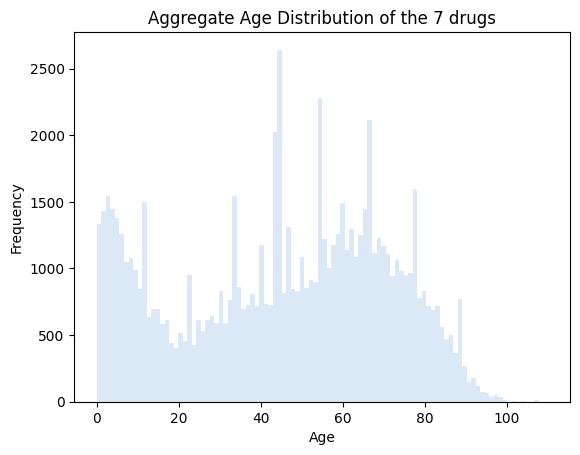

In [50]:
#Plot the age column
sns.set_palette('Blues')
df['age'].plot(kind='hist', bins=100)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Aggregate Age Distribution of the 7 drugs')
print(f'Here is the number of null values: {df['age'].isnull().sum()}')
print(f'Here is the units of the age column: {df['age_cod'].unique()}')

C:\Users\gabel\AppData\Local\Temp\ipykernel_20284\2411283441.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bracket_counts = df_copy.groupby(['age_bracket'])['ps_drugname'].value_counts().unstack()


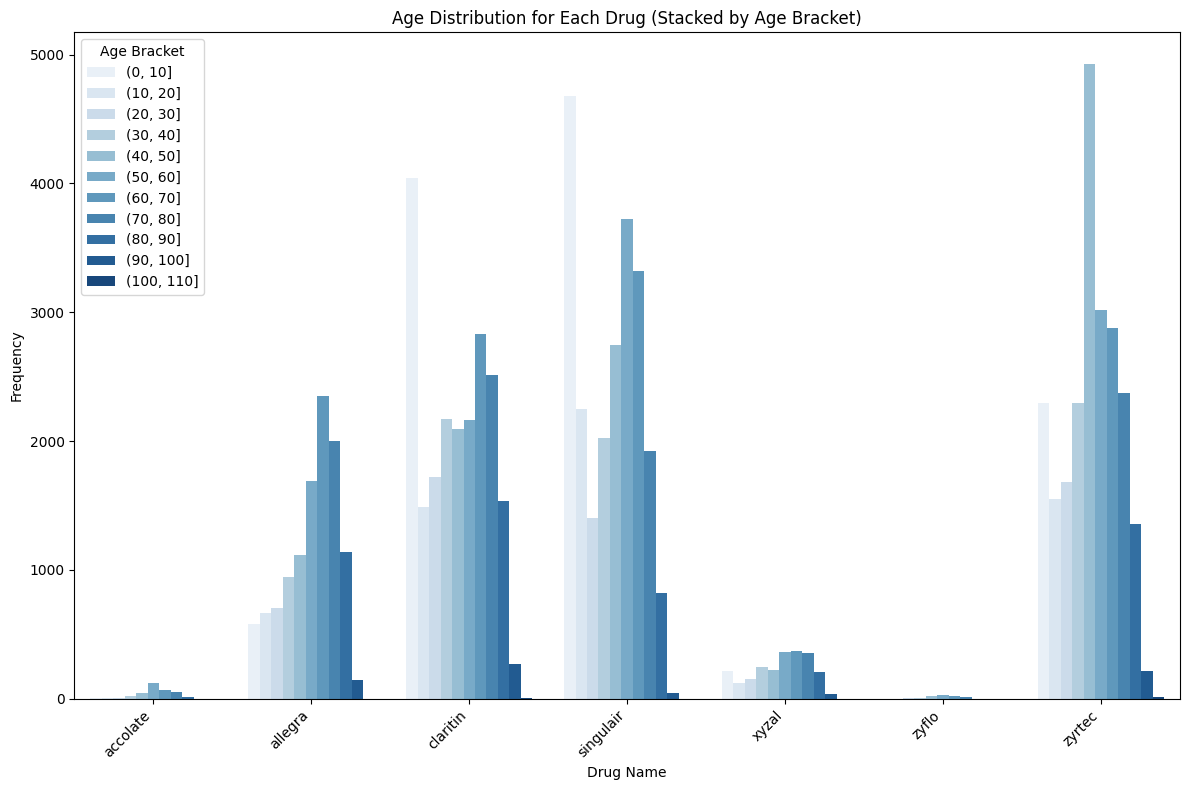

In [51]:
# Filter out antihistamines and leukotriene receptor antagonists
df_copy = df[df['ps_drugname'].isin(df_target_drugs['Brand Name'].unique())][['ps_drugname','age']]


#Make a histogram of the age for each drug in age brackets
brackets = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
df_copy['age_bracket'] = pd.cut(df_copy['age'], brackets)

age_bracket_counts = df_copy.groupby(['age_bracket'])['ps_drugname'].value_counts().unstack()

age_bracket_counts = age_bracket_counts.reset_index().melt(id_vars='age_bracket', var_name='Drug', value_name='Count')

# Create a bar plot with Seaborn
#Make the background black
plt.figure(figsize=(12, 8))
sns.barplot(
    data=age_bracket_counts,
    x='Drug',
    y='Count',
    hue='age_bracket',
    palette='Blues',
)

# Set labels and title
plt.xlabel('Drug Name')
plt.ylabel('Frequency')
plt.title('Age Distribution for Each Drug (Stacked by Age Bracket)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Bracket')
plt.tight_layout()
plt.show()

In [52]:
#Filtering the data to only include the drugs in the Target Drugs sheet
df = df[df['ps_drugname'].notnull()]
df = df[(df['ps_drugname'].isin(df_target_drugs['Brand Name']))]

#Convert the fda_dt column to datetime
df['fda_dt'] = pd.to_datetime(df['fda_dt'])
df['event_dt'] = pd.to_datetime(df['event_dt'])

print(df['ps_drugname'].unique())
print(df['fda_dt'].dt.year.unique())

['singulair' 'allegra' 'zyrtec' 'claritin' 'accolate' 'zyflo' 'xyzal']
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 1998 2000 2020 2021 2022 2023 2024]


Let's look at the null values to see what aspects of our data might be more useful to us.

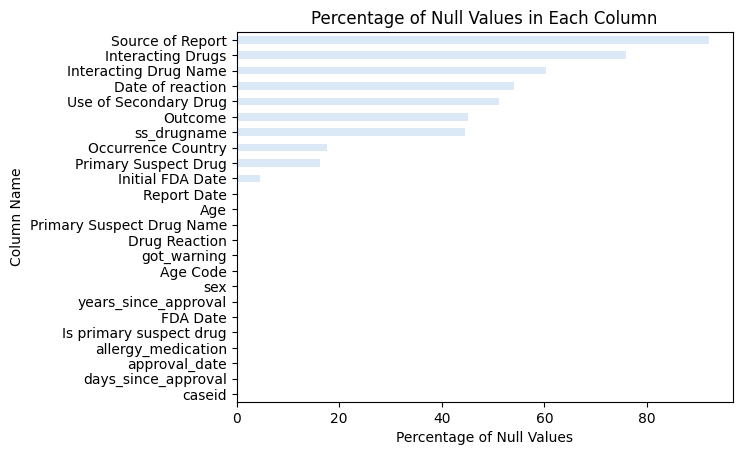

╒═══════════════════════════╤═══════════════╤══════════════════════════╕
│ column_name               │   null_values │   percentage_null_values │
╞═══════════════════════════╪═══════════════╪══════════════════════════╡
│ Source of Report          │         74497 │                   92.069 │
├───────────────────────────┼───────────────┼──────────────────────────┤
│ Interacting Drugs         │         61388 │                   75.868 │
├───────────────────────────┼───────────────┼──────────────────────────┤
│ Interacting Drug Name     │         48768 │                   60.271 │
├───────────────────────────┼───────────────┼──────────────────────────┤
│ Date of reaction          │         43777 │                   54.103 │
├───────────────────────────┼───────────────┼──────────────────────────┤
│ Use of Secondary Drug     │         41448 │                   51.225 │
├───────────────────────────┼───────────────┼──────────────────────────┤
│ Outcome                   │         36513 │      

In [53]:
def null_values(df):    
#Find the number of null values in each column
    null_values = df.isnull().sum()
    #Give me the percentage of null values in each column
    percentage_null_values = df.isnull().mean().round(5) * 100
    #make null_values and percentage_null_values into a DataFrame
    null_values = pd.DataFrame(null_values, columns=['null_values'])
    percentage_null_values = pd.DataFrame(percentage_null_values, columns=['percentage_null_values'])
    #print(percentage_null_values)
    #Combine the two DataFrames
    null_values_stuff = pd.concat([null_values, percentage_null_values], axis=1)
    #Make null_values_stuff into a DataFrame
    null_values_stuff = pd.DataFrame(null_values_stuff)
    null_values_stuff.index.name = 'column_name'

    #Rename some of the index names
    null_values_stuff = null_values_stuff.rename(index={
        'ps_drugname': 'Primary Suspect Drug Name',
        'prod_ai': 'Product Active Ingredient',
        'rept_cod': 'Report Type Code',
        'rept_dt': 'Report Date',
        'auth_num': 'Authority Number',
        'mfr_num': 'Manufacturer Number',
        'mfr_sndr': 'Manufacturer Sender',
        'lit_ref': 'Literature Reference',
        'age': 'Age',
        'age_cod': 'Age Code',
        'age_grp' : 'Age Group',
        'occr_country': 'Occurrence Country',
        'reaction_pt': 'Drug Reaction',
        'event_dt': 'Date of reaction',
        'fda_dt' : 'FDA Date',
        'rept_dt': 'Report Date',
        'ps_indi_dt' : 'Primary Suspect Drug',
        'outc_cod': 'Outcome',
        'rpsr_cod' : 'Source of Report',
        'c_i_indi_pt' : 'Interacting Drugs',
        'ss_indi_pt' : 'Use of Secondary Drug',
        'c_i_drugname' : 'Interacting Drug Name',
        'ps_indi_pt' : 'Primary Suspect Drug',
        'init_fda_dt' : 'Initial FDA Date',
        'is_p' : 'Is primary suspect drug',
        'is_s' : 'Is secondary suspect drug',
        'is_p_and_s' : 'Is primary and secondary suspect drug'
    }, errors='ignore')                                                                          

    #Bar plot of the percentage of null values in each column
    null_values_stuff['percentage_null_values'].sort_values(ascending=True).plot(kind='barh')
    plt.ylabel('Column Name')
    plt.xlabel('Percentage of Null Values')
    plt.title('Percentage of Null Values in Each Column')
    plt.show()

    table = tabulate(null_values_stuff.sort_values(by='percentage_null_values', ascending=False), headers='keys', tablefmt='fancy_grid')
    return table

print(null_values(df))

Look at the distribution of when fda received the case report aggregated for each year from 2004 to 2019

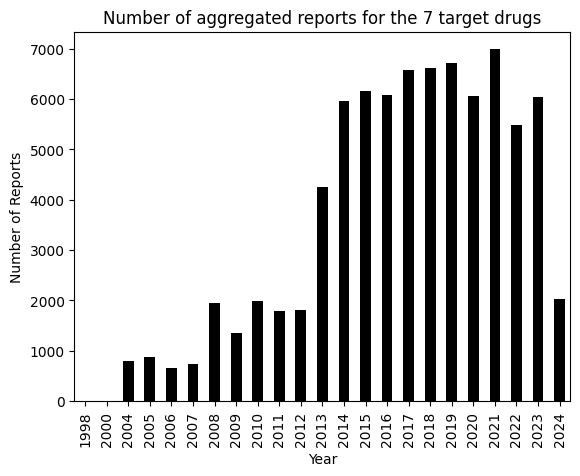

In [54]:
df['fda_dt'].dt.year.value_counts().sort_index().plot(kind='bar', color='black')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.title('Number of aggregated reports for the 7 target drugs')
plt.show()

Look at the difference between when the FDA received the case and when the adverse reactions started occuring. This may be insightful as to show potential biases and may be helpful with respect to data cleaning.

count    36904.000000
mean       325.836820
std        749.741443
min          1.000000
25%         20.000000
50%         79.000000
75%        317.000000
max      23078.000000
Name: lag, dtype: float64


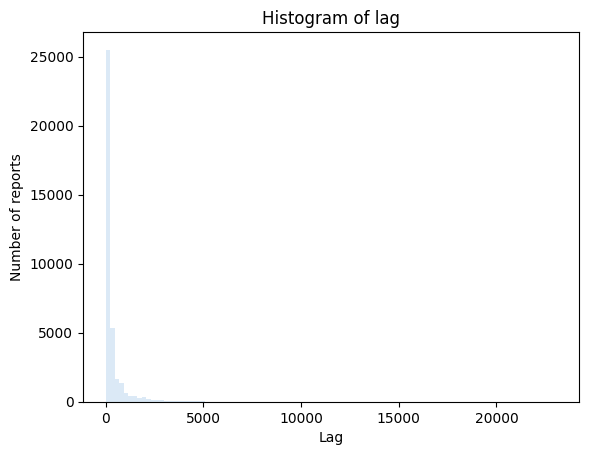

In [55]:
df['lag'] = df['fda_dt'] - df['event_dt']
df['lag'] = df['lag'].dt.days
df['lag'] = df['lag'].astype(float)
df = df[df['lag'] > 0]
print(df['lag'].describe())
df['lag'].plot(kind='hist', bins=100)
plt.xlabel('Lag')
plt.ylabel('Number of reports')
plt.title('Histogram of lag')
plt.show()

Looking at the distribution when fda received the case report for the primary drugs for every year from 2004 to 2019

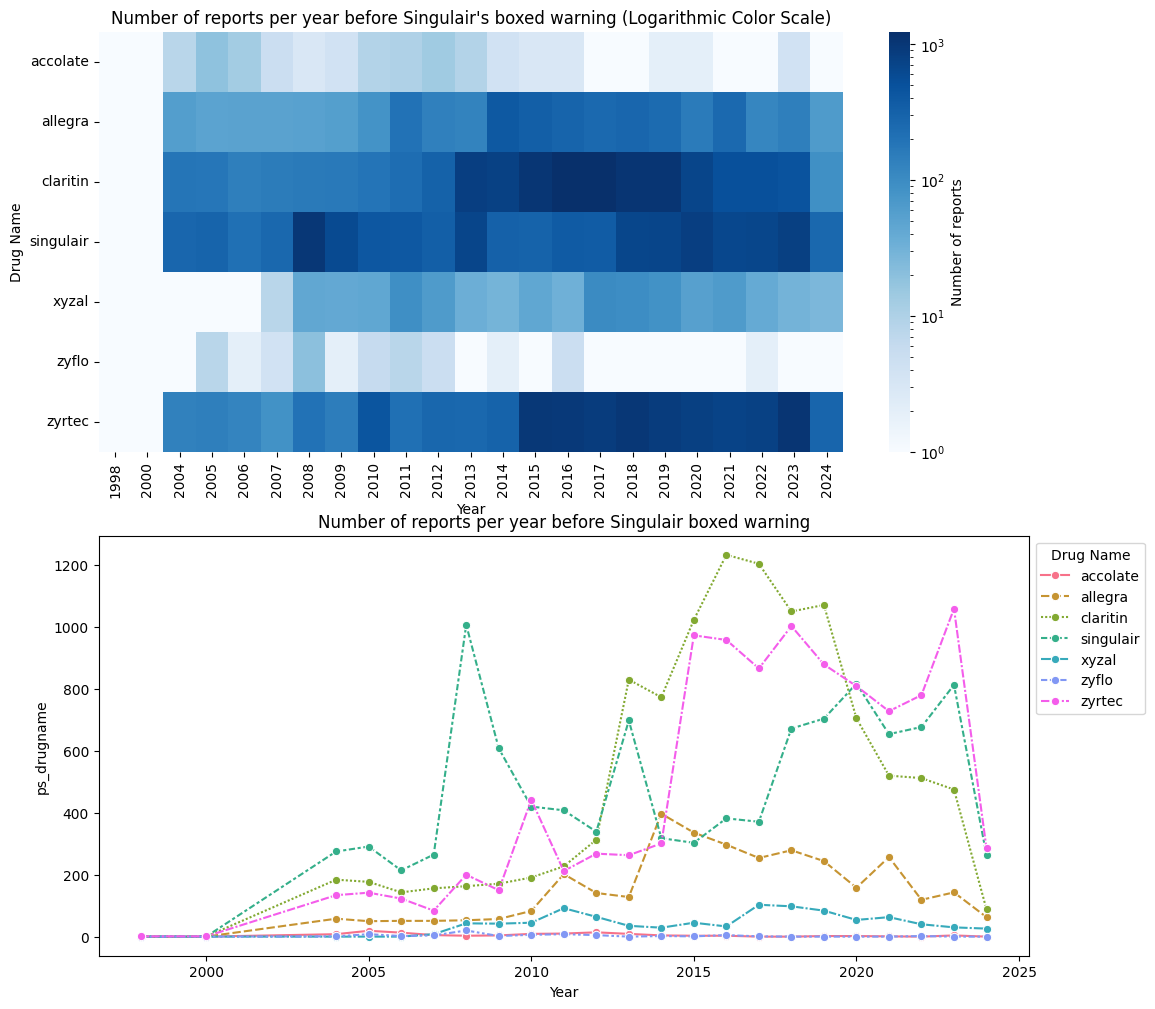

╒═══════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ ps_drugname   │   1998 │   2000 │   2004 │   2005 │   2006 │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞═══════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ accolate      │      0 │      0 │      8 │     19 │     13 │      5 │      3 │      4 │      9 │     10 │     14 │      9 │      4 │      3 │      3 │      0 │      0 │      2 │      2 │      1 │      0 │      4 │      0 │
├───────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼──

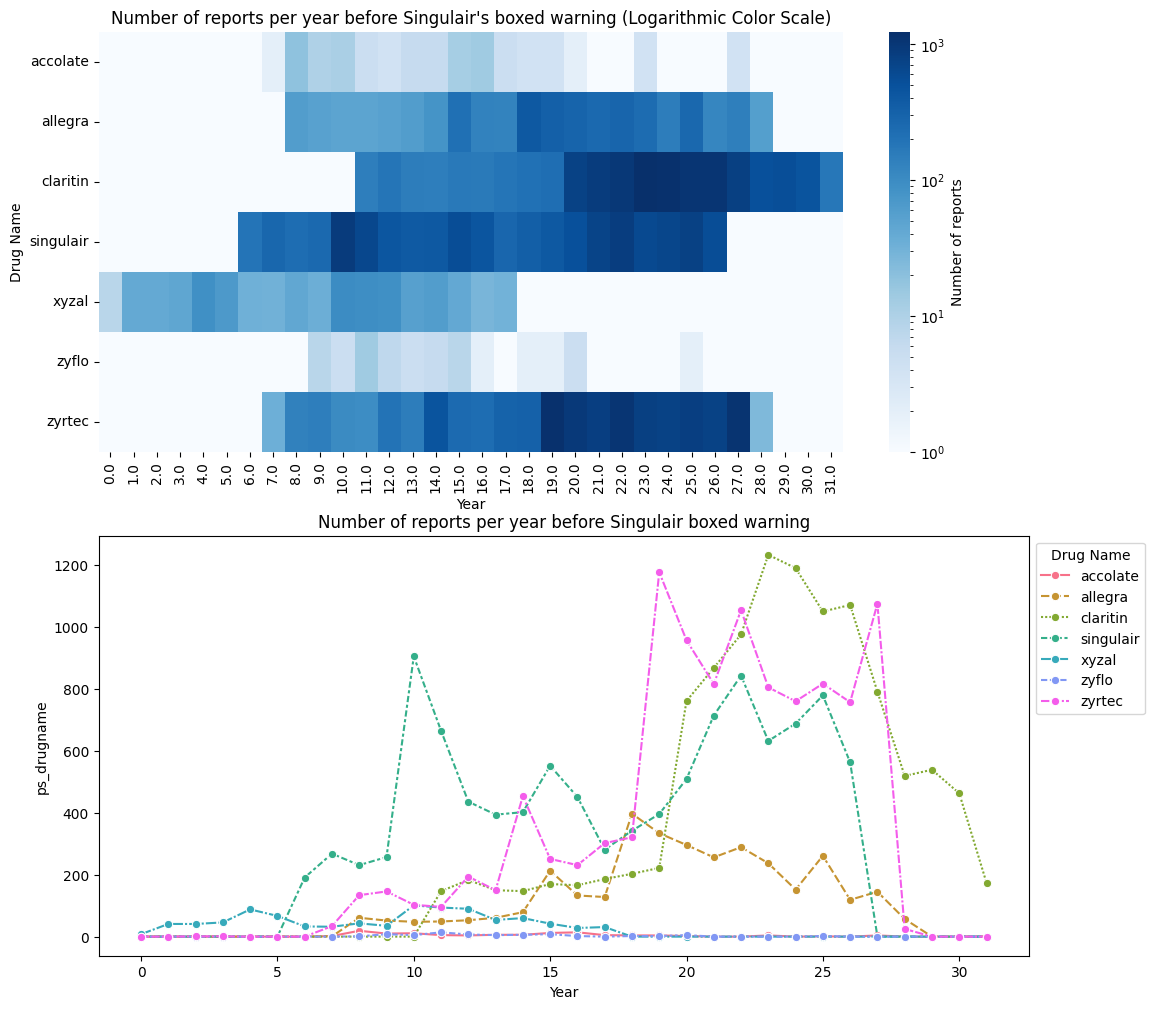

╒═══════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ ps_drugname   │   0.0 │   1.0 │   2.0 │   3.0 │   4.0 │   5.0 │   6.0 │   7.0 │   8.0 │   9.0 │   10.0 │   11.0 │   12.0 │   13.0 │   14.0 │   15.0 │   16.0 │   17.0 │   18.0 │   19.0 │   20.0 │   21.0 │   22.0 │   23.0 │   24.0 │   25.0 │   26.0 │   27.0 │   28.0 │   29.0 │   30.0 │   31.0 │
╞═══════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ accolate      │     0 │     0 │     0 │     0 │     0 │     0 │     0 │     2 │    19 │    10 │     11 │      

In [56]:
df_year = df.copy()
df_year['year'] = df_year['fda_dt'].dt.year
df_year1 = df_year.groupby('ps_drugname')['year'].value_counts().unstack().fillna(0.1)
df_year2 = df_year.groupby('ps_drugname')['years_since_approval'].value_counts().unstack().fillna(0.1)

def reports_year(df_year):
    plt.figure(figsize=(12, 12))

    plt.subplot(2,1,1)
    sns.heatmap(df_year, cmap='Blues', annot=False , fmt=".0f", norm=LogNorm(vmin=1, vmax=df_year.melt(col_level=0).max()['value']+1),
        linecolor='black', cbar_kws={'label': 'Number of reports'}) 
    plt.xlabel('Year')
    plt.ylabel('Drug Name')
    plt.yticks(rotation=0)
    plt.title("Number of reports per year before Singulair's boxed warning (Logarithmic Color Scale)")

    plt.subplot(2,1,2)
    #linelplot
    sns.lineplot(data=df_year.T, marker='o')
    plt.xlabel('Year')
    plt.ylabel(f'{df_year.index.name}')
    plt.title('Number of reports per year before Singulair boxed warning')
    plt.legend(title='Drug Name', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    df_year = df_year.round(0).astype(int)
    return(tabulate(df_year, headers='keys', tablefmt='fancy_grid'))

print(reports_year(df_year1))
print(reports_year(df_year2))

Using the 7 brand name drugs to see how many unique case reports there were for each drug in either case as being the primary and or the secondary drug suspected.

In [57]:
df_test = df['ps_drugname'].value_counts()
#Get the data type of df_test
df_test = df_test.to_frame()
#Change the column name to Frequency
df_test.columns = ['Frequency']
header = ['Brand Name', 'Frequency']
print(tabulate(df_test, headers=header, tablefmt='fancy_grid'))

╒══════════════╤═════════════╕
│ Brand Name   │   Frequency │
╞══════════════╪═════════════╡
│ claritin     │       11209 │
├──────────────┼─────────────┤
│ zyrtec       │       10661 │
├──────────────┼─────────────┤
│ singulair    │       10499 │
├──────────────┼─────────────┤
│ allegra      │        3421 │
├──────────────┼─────────────┤
│ xyzal        │         934 │
├──────────────┼─────────────┤
│ accolate     │         113 │
├──────────────┼─────────────┤
│ zyflo        │          67 │
╘══════════════╧═════════════╛


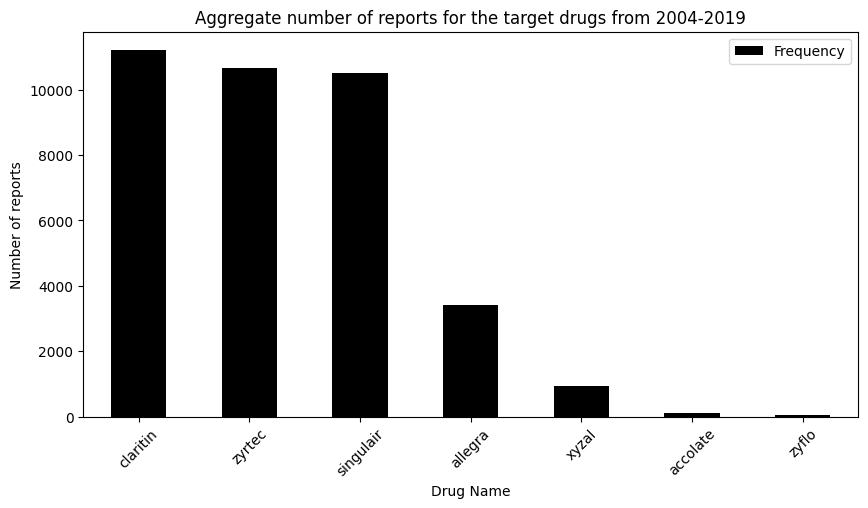

In [58]:

#Set background color to white
df_test.plot(kind='bar', figsize=(10, 5), color='black')
plt.title('Aggregate number of reports for the target drugs from 2004-2019')
plt.xlabel('Drug Name')
plt.xticks(rotation=45)
plt.ylabel('Number of reports')
plt.show()

Next, look at reaction types overall, 

Checking types of delimiters in the reaction_pt column

In [59]:

def detect_delimiter(text):
    # List of common delimiters to check
    common_delimiters = [',', ';', '\t', '|', ':', '\n']

    # Count occurrences of each delimiter in the text
    delimiter_counts = Counter({delimiter: text.count(delimiter) for delimiter in common_delimiters})
    return delimiter_counts    

#Read the df reaction_pt column to see how the data is separated
delimiter = detect_delimiter(df['reaction_pt'].str.cat(sep=''))
#Find the most common delimites that are greater than 0
delimiters = {delimiter: count for delimiter, count in delimiter.items() if count > 0}
#Get the delimiter
delimiters = list(delimiters.keys())
print(delimiters)

[',', ';']


In [60]:
#Makes every reaction entry in a report a separate row for all delimiters
df_reaction_test = df.assign(reaction_pt=df['reaction_pt'].str.split(r',\s*|;')).explode('reaction_pt')

# df_reaction_test = df.assign(reaction_pt=df['reaction_pt'].str.split(';')).explode('reaction_pt')
# df_reaction_test = df_reaction_test.assign(reaction_pt=df_reaction_test['reaction_pt'].str.split(',')).explode('reaction_pt')


#Lowercase strings and strips whitespace in the Reaction column in df_reaction_test
df_reaction_test['reaction_pt'] = df_reaction_test['reaction_pt'].str.strip().str.lower()

#Lowercase strings in the Reaction column in df_psychiatric
df_psychiatric['Reaction'] = df_psychiatric['Reaction'].str.strip().str.lower()

#Filter the data to only include the reactions in the Psychiatric Disorder Reac Grp sheet
df_reaction_test = df_reaction_test[df_reaction_test['reaction_pt'].isin(df_psychiatric['Reaction'].unique())]

df_reaction_test['year'] = df_reaction_test['fda_dt'].dt.year


#Makes the reaction column in df_reaction_test a category
df_reaction_counts = df_reaction_test['reaction_pt'].value_counts()
df_reaction_counts = df_reaction_counts.to_frame()

#Limit the number of rows to 10
df_reaction_counts = df_reaction_counts
df_reaction_counts.columns = ['Frequency']
header = ['Reaction', 'Frequency']
print(tabulate(df_reaction_counts, headers=header, tablefmt='fancy_grid'))  # Print the table

╒═══════════════════════════════════════════════════╤═════════════╕
│ Reaction                                          │   Frequency │
╞═══════════════════════════════════════════════════╪═════════════╡
│ anxiety                                           │        2128 │
├───────────────────────────────────────────────────┼─────────────┤
│ insomnia                                          │        1956 │
├───────────────────────────────────────────────────┼─────────────┤
│ depression                                        │        1643 │
├───────────────────────────────────────────────────┼─────────────┤
│ suicidal ideation                                 │        1246 │
├───────────────────────────────────────────────────┼─────────────┤
│ aggression                                        │        1188 │
├───────────────────────────────────────────────────┼─────────────┤
│ hallucination                                     │        1059 │
├───────────────────────────────────────────────

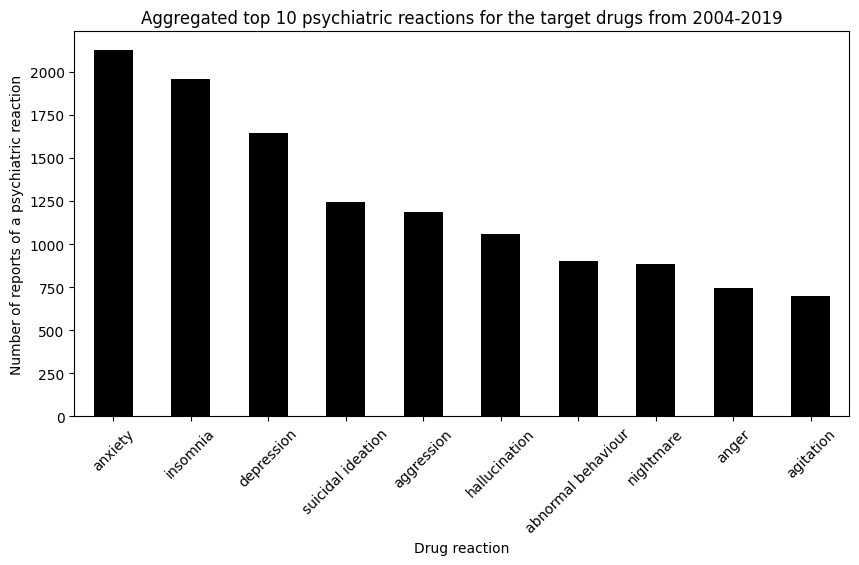

In [61]:
plt.style.use('default')
#Get top 10
df_reaction_counts = df_reaction_counts.head(10)
df_reaction_counts.plot(kind='bar', figsize=(10, 5), color='black')
plt.title('Aggregated top 10 psychiatric reactions for the target drugs from 2004-2019')
plt.xlabel('Drug reaction')
plt.xticks(rotation=45)
plt.ylabel('Number of reports of a psychiatric reaction')
plt.legend().remove()
plt.show()

Now look at the top 10 overall reactions for each drug in a heat map format

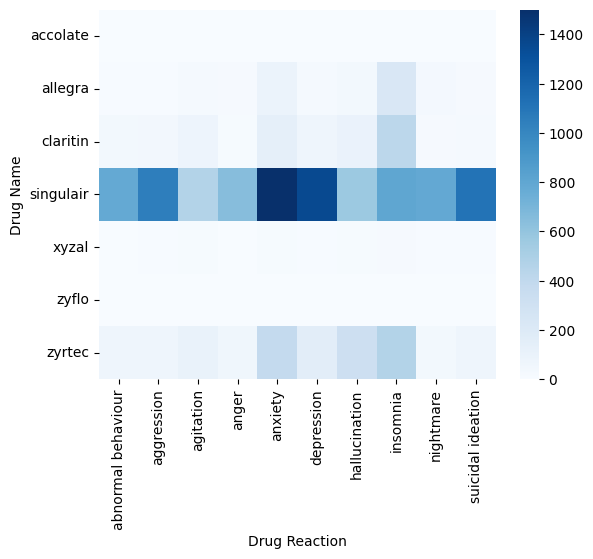

╒═══════════════╤══════════════════════╤══════════════╤═════════════╤═════════╤═══════════╤══════════════╤═════════════════╤════════════╤═════════════╤═════════════════════╕
│ ps_drugname   │   abnormal behaviour │   aggression │   agitation │   anger │   anxiety │   depression │   hallucination │   insomnia │   nightmare │   suicidal ideation │
╞═══════════════╪══════════════════════╪══════════════╪═════════════╪═════════╪═══════════╪══════════════╪═════════════════╪════════════╪═════════════╪═════════════════════╡
│ accolate      │                    0 │            0 │           1 │       0 │         3 │            4 │               0 │          0 │           0 │                   2 │
├───────────────┼──────────────────────┼──────────────┼─────────────┼─────────┼───────────┼──────────────┼─────────────────┼────────────┼─────────────┼─────────────────────┤
│ allegra       │                    6 │            8 │          26 │      21 │        89 │           26 │              39 │      

In [62]:
#Filter df_reaction_test to only include the reactions in re reaction_pt column
test = df_reaction_test[df_reaction_test['reaction_pt'].isin(df_reaction_counts.index)]
test = test.groupby('ps_drugname')['reaction_pt'].value_counts()
test = test.to_frame()
#Then make into a heatmap
test = test.unstack().fillna(0)
test.columns = test.columns.droplevel()
test = test.astype(int)
sns.heatmap(test, cmap='Blues')
plt.xlabel('Drug Reaction')
plt.ylabel('Drug Name')
plt.show()

print(tabulate(test, headers='keys', tablefmt='fancy_grid'))

Although we are looking at the top 10 conditions, it might be interesting to look at severe psychartic conditions like suicide and its corresponding conditions to see if certain drugs have more suicides as a relative percentage compared to other suicidal conditions

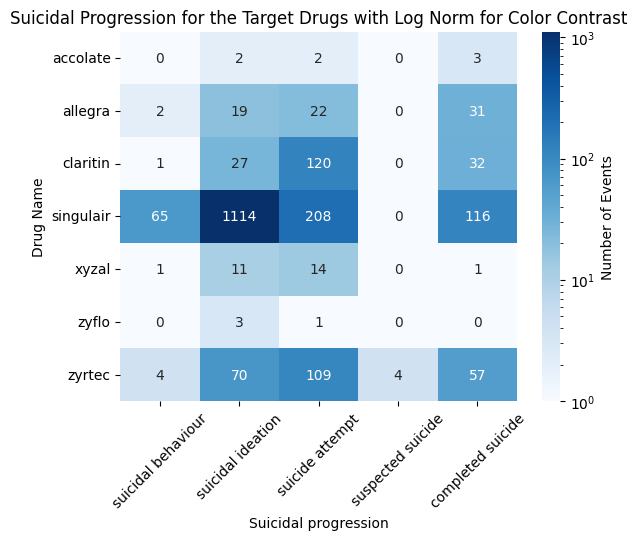

╒════════════════════╤════════════╤═══════════╤════════════╤═════════════╤═════════╤═════════╤══════════╕
│ reaction_pt        │   accolate │   allegra │   claritin │   singulair │   xyzal │   zyflo │   zyrtec │
╞════════════════════╪════════════╪═══════════╪════════════╪═════════════╪═════════╪═════════╪══════════╡
│ suicidal behaviour │          0 │         2 │          1 │          65 │       1 │       0 │        4 │
├────────────────────┼────────────┼───────────┼────────────┼─────────────┼─────────┼─────────┼──────────┤
│ suicidal ideation  │          2 │        19 │         27 │        1114 │      11 │       3 │       70 │
├────────────────────┼────────────┼───────────┼────────────┼─────────────┼─────────┼─────────┼──────────┤
│ suicide attempt    │          2 │        22 │        120 │         208 │      14 │       1 │      109 │
├────────────────────┼────────────┼───────────┼────────────┼─────────────┼─────────┼─────────┼──────────┤
│ suspected suicide  │          0 │         0 

In [63]:
# Using regex to match multiple strings and filter the data for specific chronological events
def conditions(present_c, conditions_list):
    missing_c =  set(conditions_list).difference(present_c)
    return missing_c

s_conditions = ['suicidal behaviour',
       'suicidal ideation', 'suicide attempt', 'suspected suicide', 'completed suicide']

suicide_events = df_reaction_test.loc[df_reaction_test['reaction_pt'].str.contains('suicidal behaviour|suicidal ideation|suicide attempt|suspected suicide|completed suicide', case=False, na=False)]
suicide_events = suicide_events.groupby('ps_drugname')['reaction_pt'].value_counts()
suicide_events = suicide_events.to_frame()
suicide_events = suicide_events.unstack().fillna(0)
suicide_events.columns = suicide_events.columns.droplevel()
#Divide every column by the sum of each row

# Divide every element by the sum of each row; creating percentages
#suicide_events = (suicide_events.div(suicide_events.sum(axis=1), axis=0))*100

missing_c = conditions(suicide_events.columns, s_conditions)
suicide_events = suicide_events.transpose()

for condition in missing_c:
    suicide_events.loc[condition] = [0.0] * suicide_events.shape[1]

suicide_events = suicide_events.reindex(s_conditions)

#Fill in any value in suicide_events from 0 to 0.1
suicide_events = suicide_events.replace(0, 0.1, inplace=False)

#Make white background
plt.style.use('default')
sns.heatmap(suicide_events.transpose(), cmap='Blues', annot=True, fmt=".0f", norm=LogNorm(vmin=1, vmax=suicide_events.values.max() + 1),
    cbar_kws={'label': 'Number of Events'})
plt.xlabel('Suicidal progression')
plt.ylabel('Drug Name')
plt.yticks(rotation=360)
plt.xticks(rotation=45)
plt.title('Suicidal Progression for the Target Drugs with Log Norm for Color Contrast')
plt.show()
suicide_events = suicide_events.round(0).astype(int)
print(tabulate(suicide_events, headers='keys', tablefmt='fancy_grid'))

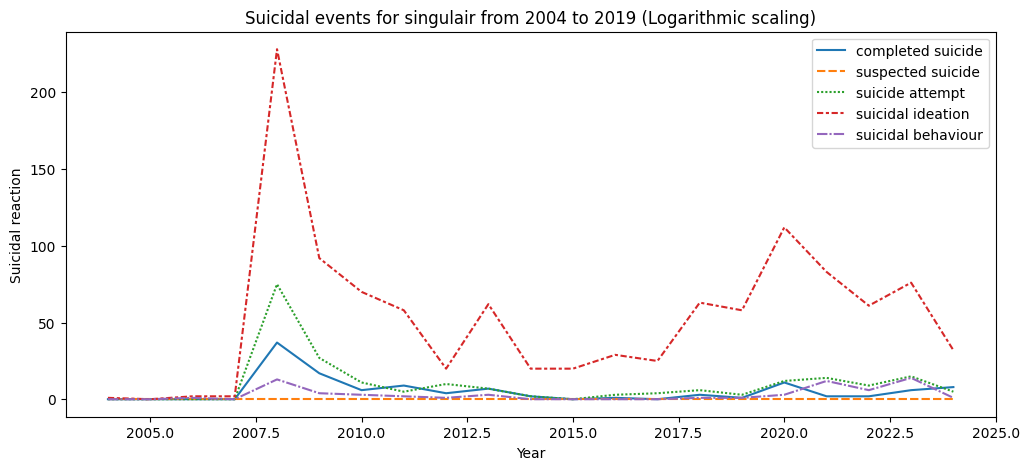

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2004 │   2005 │   2006 │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      0 │      0 │      0 │      0 │     37 │     17 │      6 │      9 │      4 │      7 │      2 │      0 │      1 │      0 │      3 │      1 │     11 │      2 │      2 │      6 │      8 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────

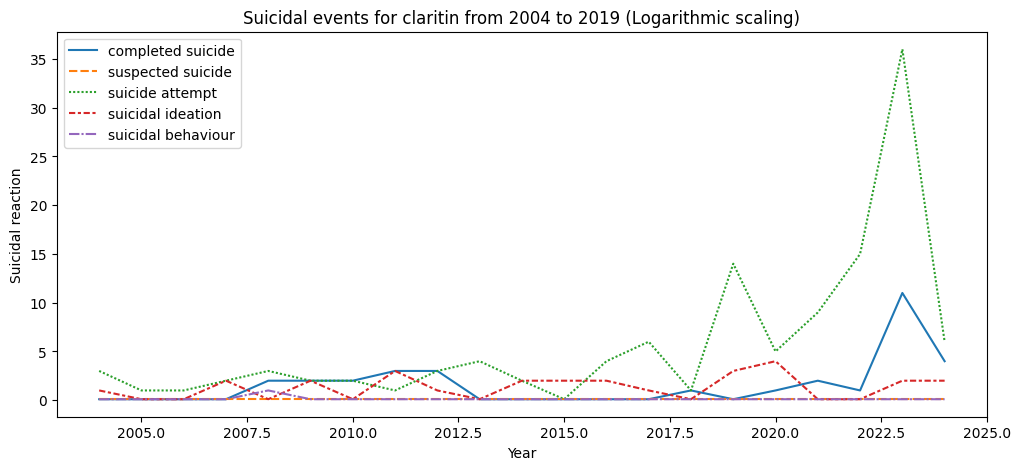

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2004 │   2005 │   2006 │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      0 │      0 │      0 │      0 │      2 │      2 │      2 │      3 │      3 │      0 │      0 │      0 │      0 │      0 │      1 │      0 │      1 │      2 │      1 │     11 │      4 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────

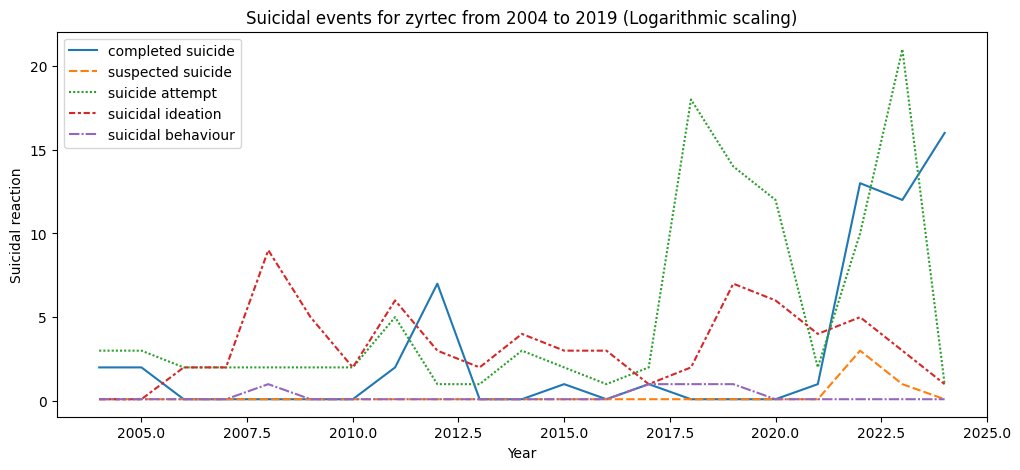

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2004 │   2005 │   2006 │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      2 │      2 │      0 │      0 │      0 │      0 │      0 │      2 │      7 │      0 │      0 │      1 │      0 │      1 │      0 │      0 │      0 │      1 │     13 │     12 │     16 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────

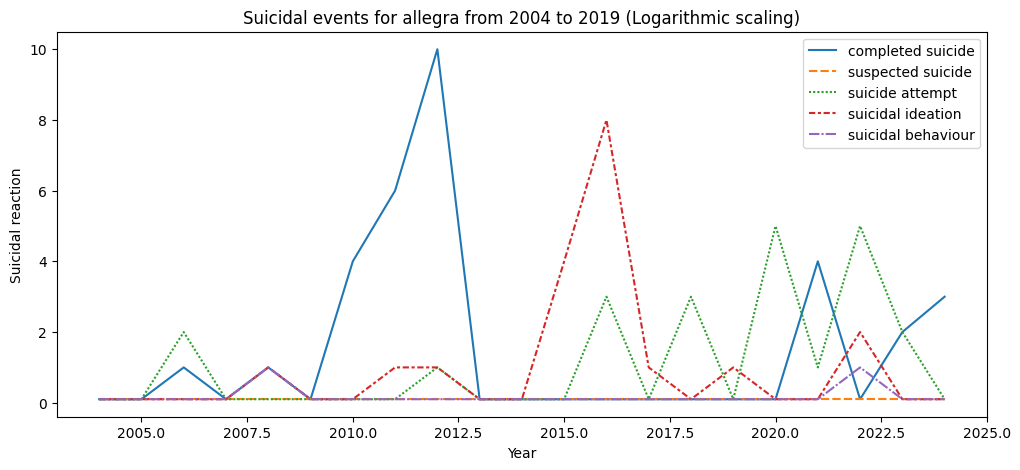

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2004 │   2005 │   2006 │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      0 │      0 │      1 │      0 │      1 │      0 │      4 │      6 │     10 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      4 │      0 │      2 │      3 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────

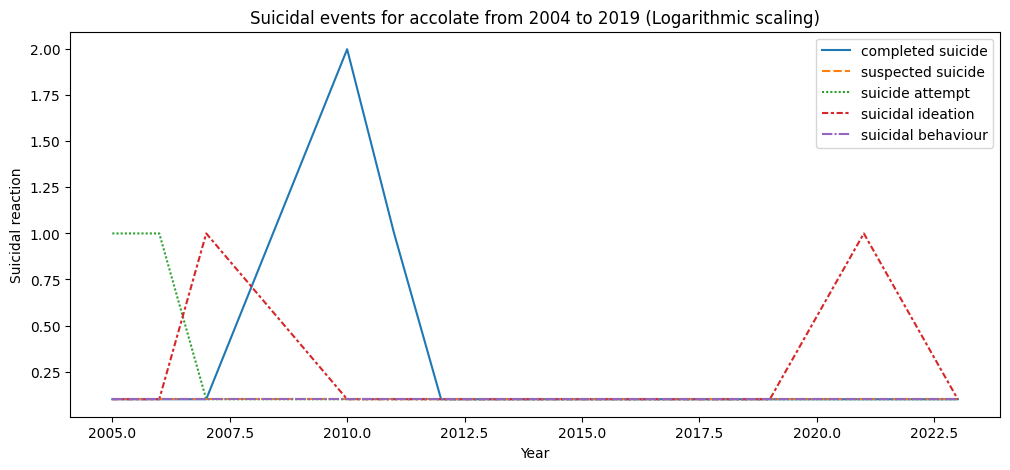

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2005 │   2006 │   2007 │   2010 │   2011 │   2012 │   2013 │   2014 │   2016 │   2019 │   2021 │   2023 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      0 │      0 │      0 │      2 │      1 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ suspected suicide  │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ suicide attempt    │      1 │      1 │      0 │      0 │      0 │      0 │      0

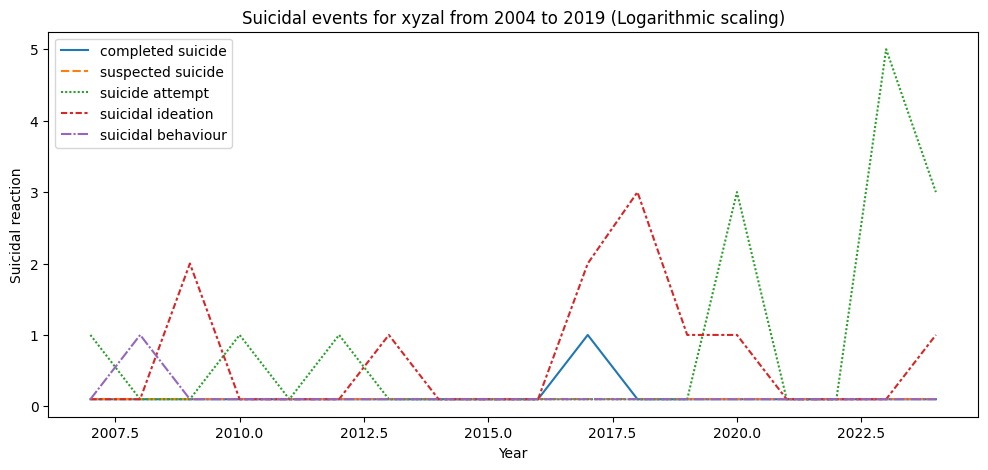

╒════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│ reaction_pt        │   2007 │   2008 │   2009 │   2010 │   2011 │   2012 │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2021 │   2022 │   2023 │   2024 │
╞════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ completed suicide  │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │      1 │      0 │      0 │      0 │      0 │      0 │      0 │      0 │
├────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ suspected suicide  │      0 │      0 │      0 │      0 │      0 │      0 

In [64]:
def conditions(present_c, conditions_list):
    missing_c =  set(conditions_list).difference(present_c)
    return missing_c


def suicidal_issues(df:pd.DataFrame, drugname:str, condition_list:list):
    df = df[df['ps_drugname'] == drugname]
    
    #Reverse order of condition_list so least to most severe
    condition_list = condition_list[::-1]

    df_new = df[df['reaction_pt'].isin(condition_list)]
        
    #Finds missing years from subsetting the dataset
    missing_years = conditions(df_new['year'].unique(), df['year'].unique())

    #Groupby the year, find the frequency of the subsetted counts
    df_new = df_new.groupby('year')['reaction_pt'].value_counts().unstack().fillna(0)

    #Create a new row for every missing year and fill every entry with zero
    for year in missing_years:
        df_new.loc[year] = [0.0] * df_new.shape[1]

    #Sorts the years
    df_new = df_new.sort_index()

    #Looking at missing conditions where there is no data
    missing_conditions = conditions(df_new.columns, condition_list)

    #Transpose for looking better
    df_new = df_new.transpose()

    for condition in missing_conditions:
        df_new.loc[condition] = [0.0] * df_new.shape[1]

    #Sort index by the order of the condition list
    df_new = df_new.reindex(condition_list)
    df_new = df_new.replace(0, 0.1, inplace=False)

    #Puts things in percentages
    #df_percent = round((df_new.div(df_new.sum(axis=1), axis=0))*100, 0)
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_new.transpose())
    #sns.heatmap(df_new, cmap="Blues", annot=True, fmt='.0f', annot_kws={"size": 12, "color": "white"}, norm=LogNorm(vmin=1, vmax=df_new.melt(col_level=0).max()['value']+1), linewidths=0.5,
    #linecolor='black', cbar_kws={'label': 'Number of reports'})
    plt.xlabel("Year")
    plt.yticks(rotation=0)
    plt.ylabel("Suicidal reaction")
    plt.title(f"Suicidal events for {drugname} from 2004 to 2019 (Logarithmic scaling)")
    plt.legend()
    plt.show()

    df_new = df_new.round(0).astype(int)
    #Return a table of the raw data
    return tabulate(df_new, headers='keys' ,tablefmt='fancy_grid')

s_conditions = ['suicidal behaviour',
       'suicidal ideation', 'suicide attempt', 'suspected suicide', 'completed suicide']
drugs_to_look_at = ['singulair', 'claritin', 'zyrtec', 'allegra', 'accolate', 'xyzal']
for drug in drugs_to_look_at:
    chronlogical_suicide = suicidal_issues(df_reaction_test, drug, s_conditions)
    print(chronlogical_suicide)

The previous heat map only shows the top 10 reactions overall, against all drugs and this may be biased towards Singulair, since most of the case reports are for Singulair, so it may be interesting to look at the other primary drugs(Accolate, Allegra, etc...) and there top 10 reactions over time as further back in the report, there was a heatmap showing the number of cases received by FDA over time and this function is specifically looking into this in more detail, may provide more information on what influenced FDA to take action on Singulair and not other drugs.

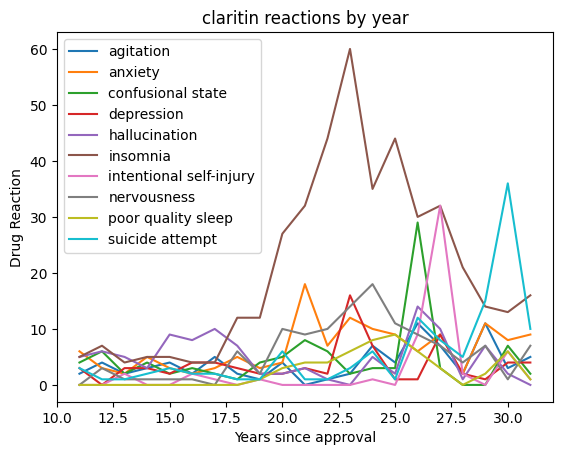

╒════╤═════════════════════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│    │ reaction_pt             │   11.0 │   12.0 │   13.0 │   14.0 │   15.0 │   16.0 │   17.0 │   18.0 │   19.0 │   20.0 │   21.0 │   22.0 │   23.0 │   24.0 │   25.0 │   26.0 │   27.0 │   28.0 │   29.0 │   30.0 │   31.0 │
╞════╪═════════════════════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│  0 │ agitation               │      2 │      4 │      2 │      3 │      4 │      2 │      5 │      2 │      1 │      4 │      0 │      1 │      2 │      7 │      4 │     11 │      7 │      2 │     11 │      3 │      5 │
├────┼─────────────────────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────

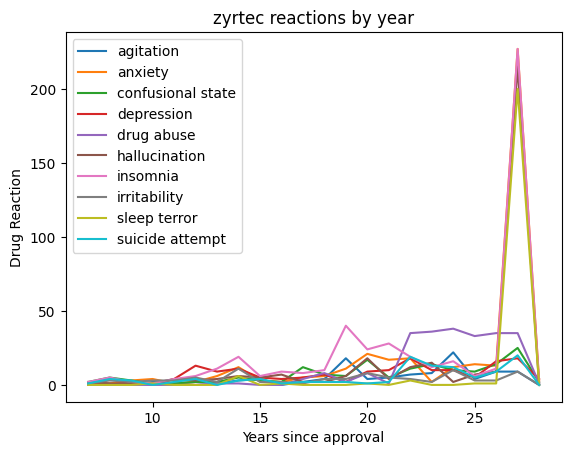

╒════╤═══════════════════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│    │ reaction_pt       │   7.0 │   8.0 │   9.0 │   10.0 │   11.0 │   12.0 │   13.0 │   14.0 │   15.0 │   16.0 │   17.0 │   18.0 │   19.0 │   20.0 │   21.0 │   22.0 │   23.0 │   24.0 │   25.0 │   26.0 │   27.0 │   28.0 │
╞════╪═══════════════════╪═══════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│  0 │ agitation         │     1 │     1 │     0 │      2 │      1 │      2 │      1 │      3 │      4 │      0 │      2 │      4 │     18 │      4 │      5 │      7 │      8 │     22 │      4 │      9 │      9 │      0 │
├────┼───────────────────┼───────┼───────┼───────┼────────┼────────┼────────┼────────┼────────┼────────┼────────

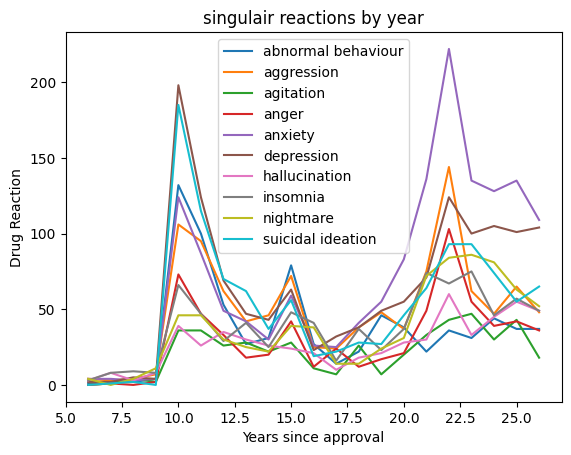

╒════╤════════════════════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╤════════╕
│    │ reaction_pt        │   6.0 │   7.0 │   8.0 │   9.0 │   10.0 │   11.0 │   12.0 │   13.0 │   14.0 │   15.0 │   16.0 │   17.0 │   18.0 │   19.0 │   20.0 │   21.0 │   22.0 │   23.0 │   24.0 │   25.0 │   26.0 │
╞════╪════════════════════╪═══════╪═══════╪═══════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│  0 │ abnormal behaviour │     1 │     2 │     2 │     4 │    132 │    100 │     53 │     27 │     31 │     79 │     27 │     14 │     22 │     46 │     38 │     22 │     36 │     31 │     44 │     37 │     37 │
├────┼────────────────────┼───────┼───────┼───────┼───────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────

In [65]:
df_reaction_test['year'] = df_reaction_test['fda_dt'].dt.year


def reasons_for_case_reports(df:pd.DataFrame, drug_name:str):
    #Filter for Zytrec and aggregate the reactions by year
    df = df[df['ps_drugname'] == drug_name]
    #Filter rows to only include the reactions in the top 10 reactions
    top_10 = df['reaction_pt'].value_counts().head(10)
    df = df[df['reaction_pt'].isin(top_10.index)]
    
    #This line is grouping by year and find the number of cases for every reaction by year, fill in missing values with 0
    df = df.groupby('years_since_approval')['reaction_pt'].value_counts().unstack().fillna(0)
    
    #Convert from float to integer
    df = df.astype(int)

    #Transpose for easier usage and manipulation
    df = df.transpose()

    #Heatmap doesn't like the resetted index
    #sns.heatmap(df, cmap='Blues')

    
    #Need to reset index to get access to column names and index names to turn into long format
    df = df.reset_index()

    df_long = df.melt(id_vars='reaction_pt', var_name='year', value_name='count')
    sns.lineplot(df_long, x='year', y='count', hue='reaction_pt')
    plt.xlabel('Years since approval')
    plt.ylabel('Drug Reaction')
    plt.title(f'{drug_name} reactions by year')
    plt.legend()
    plt.show()

    print(tabulate(df, headers='keys' ,tablefmt='fancy_grid'))
    return df


#Get top 3 drugs with most cases and plot the heatmap
top_3 = df_test.head(3).index
for drug in top_3:
    reasons_for_case_reports(df_reaction_test, drug)

We have looked at the drugs as a complete set, however it should be noted that there are 2 distinct categories, antihistamines and leukotriene receptors antagonist and it might be useful to look at these seperately and the corresponding reactions.

NOTE: Antihistamines: (Zyrtec, Claritin, Allegra, Xyzal) and Leukotrienes: (Singulair, Zyflo, Accolate)

In [66]:
#filter df_reaction_test to only include dates before 2020
df_reaction_test = df_reaction_test[df_reaction_test['fda_dt'].dt.year < 2020]

#Should have only Zyrtec, Claritin, Allegra, Xyzal
df_antihistamine = df_reaction_test[df_reaction_test['ps_drugname'].isin(['zyrtec', 'claritin', 'allegra', 'xyzal'])]
df_antihistamine_copy = df_antihistamine.copy()

#Should not have Zyrtec, Claritin, Allegra, Xyzal
df_leukotriene = df_reaction_test[~df_reaction_test['ps_drugname'].isin(['zyrtec', 'claritin', 'allegra', 'xyzal'])]
df_leukotriene_copy = df_leukotriene.copy()

# make df_antihistamine show the top 10 reactions and make a heatmap
df_antihistamine = df_antihistamine['reaction_pt'].value_counts().head(10)
df_antihistamine = df_antihistamine.to_frame()
df_antihistamine.columns = ['Frequency']
header = ['Reaction', 'Frequency']


# make df_leukotriene show the top 10 reactions and make a heatmap
df_leukotriene = df_leukotriene['reaction_pt'].value_counts().head(10)
df_leukotriene = df_leukotriene.to_frame()
df_leukotriene.columns = ['Frequency']
header = ['Reaction', 'Frequency']



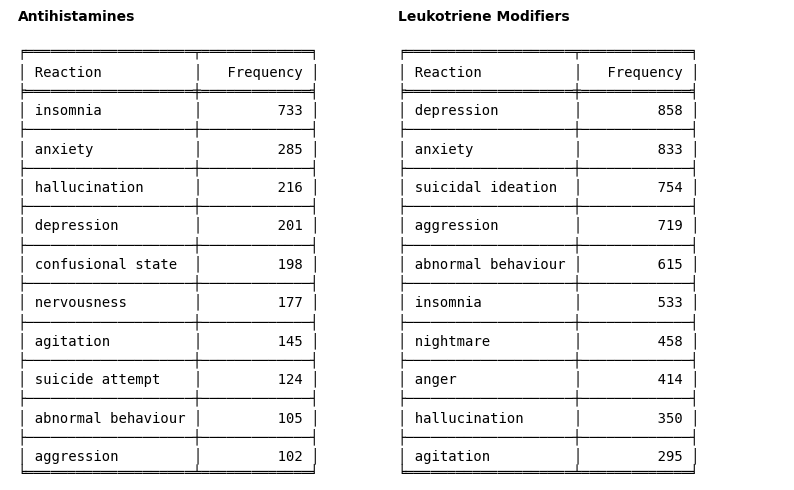

In [67]:

antihistamine_table = tabulate(df_antihistamine, headers=header, tablefmt='fancy_grid')
leukotriene_table = tabulate(df_leukotriene, headers=header, tablefmt='fancy_grid')

# Print both tables side by side using matplotlib
fig, ax = plt.subplots(figsize=(10, 4))

ax.text(0.01, 1.3, 'Antihistamines', fontsize=10, va='center', ha='left', weight='bold')
ax.text(0.5, 1.3, 'Leukotriene Modifiers', fontsize=10, va='center', ha='left', weight='bold')


# Create a text box for antihistamine table
ax.text(0.01, 0.5, antihistamine_table, fontsize=10, va='center', ha='left', family='monospace')

# Create a text box for leukotriene table
ax.text(0.5, 0.5, leukotriene_table, fontsize=10, va='center', ha='left', family='monospace')

# Remove axes for cleaner look
ax.axis('off')

plt.show()


In [68]:
# def calculate_ror_prr(df_reaction_test, antihistamine_drugs, leukotriene_drugs):
#     # Group by 'ps_drugname' and 'reaction_pt', then calculate frequency
#     df_frequency = df_reaction_test.groupby(['ps_drugname', 'reaction_pt']).size().reset_index(name='Frequency')

#     # Filter data for antihistamines and leukotrienes
#     df_antihistamine = df_frequency[df_frequency['ps_drugname'].isin(antihistamine_drugs)].set_index(['reaction_pt', 'ps_drugname'])
#     df_leukotriene = df_frequency[df_frequency['ps_drugname'].isin(leukotriene_drugs)].set_index(['reaction_pt', 'ps_drugname'])

#     # Get all unique reactions
#     all_reactions = set(df_antihistamine.index.get_level_values('reaction_pt')).union(
#         set(df_leukotriene.index.get_level_values('reaction_pt'))
#     )

#     ror_results = []
#     prr_results = []

#     # Iterate over each reaction and leukotriene drug
#     for reaction in all_reactions:
#         for drug in leukotriene_drugs:
#             # Frequency data for calculations
#             A = df_leukotriene.loc[(reaction, drug), 'Frequency'] if (reaction, drug) in df_leukotriene.index else 0
#             B = df_antihistamine.loc[reaction, 'Frequency'].sum() if reaction in df_antihistamine.index else 0
#             C = df_leukotriene.loc[df_leukotriene.index.get_level_values('ps_drugname') == drug, 'Frequency'].sum() - A
#             D = df_antihistamine['Frequency'].sum() - B

#             # Debugging information to track calculation
#             print(f"Drug: {drug}, Reaction: {reaction}, A: {A}, B: {B}, C: {C}, D: {D}")

#             # Calculate ROR and PRR, ensuring no division by zero
#             if A > 0 and B > 0 and C > 0 and D > 0:
#                 ror = (A / B) / (C / D)
#                 prr = (A / (A + C)) / (B / (B + D))
#             else:
#                 ror = 0
#                 prr = 0

#             # Append results
#             ror_results.append({'Drug': drug, 'Reaction': reaction, 'ROR': ror})
#             prr_results.append({'Drug': drug, 'Reaction': reaction, 'PRR': prr})

#             # Optional: Print the contingency table for each reaction
#             contingency_table = pd.DataFrame([[A, B], [C, D]], columns=['Antihistamines', 'Leukotriene Modifiers'], index=[f'{reaction} present', f'{reaction} absent'])
#             print(contingency_table)

#     # Convert results to DataFrames and pivot for better readability
#     ror_df = pd.DataFrame(ror_results).pivot(index='Reaction', columns='Drug', values='ROR')
#     prr_df = pd.DataFrame(prr_results).pivot(index='Reaction', columns='Drug', values='PRR')

#     # Display results in formatted tables
#     print("Reporting Odds Ratios (ROR) by Drug:")
#     print(tabulate(ror_df, headers='keys', tablefmt='fancy_grid'))

#     print("\nProportional Reporting Ratios (PRR) by Drug:")
#     print(tabulate(prr_df, headers='keys', tablefmt='fancy_grid'))

#     return ror_df, prr_df

# antihistamine_drugs = ['zyrtec', 'claritin', 'allegra', 'xyzal']
# leukotriene_drugs = ['singulair', 'accolate', 'zyflo']
# ror_df, prr_df = calculate_ror_prr(df_reaction_test, antihistamine_drugs, leukotriene_drugs)


In [69]:
def calculate_ror_prr_IC_all(df_frequency, all_reactions, condition1, condition2):

    ror_results = []
    prr_results = []


    IC_results = []

    # Iterate over each reaction and leukotriene drug
    for reaction in all_reactions:
        for drug in df_frequency[condition1].unique():
            
            #Locate the frequency of the drug and reaction in the df_frequency dataframe and sum them up, if not found set to 0
            A = df_frequency.loc[((df_frequency[condition1] == drug) & (df_frequency[condition2] == reaction)), 'Frequency'].sum() if not df_frequency[(df_frequency[condition1] == drug) & (df_frequency[condition2] == reaction)].empty else 0
            #Locate the frequency of the reaction in the df_frequency dataframe and sum them up, if not found set to 0
            B = df_frequency.loc[df_frequency[condition2] == reaction, 'Frequency'].sum() if not df_frequency[df_frequency[condition2] == reaction].empty else 0
            #Locate the frequency of the drug in the df_frequency dataframe and sum them up, if not found set to 0
            C = df_frequency.loc[df_frequency[condition1] == drug, 'Frequency'].sum() - A if not df_frequency[df_frequency[condition1] == drug].empty else 0
            #Sum up all the frequencies in the df_frequency dataframe and subtract B from it, if not found set to 0
            D = df_frequency['Frequency'].sum() - B


             # Calculate ROR, PRR, and IC with ICV from the formulas given by Dr.Narety
            if A > 0 and B > 0 and C > 0 and D > 0:
                ror = (A / B) / (C / D)
                prr = (A / (A + C)) / (B / (B + D))
                IC = np.log2((A * (A + B + C + D)) / ((A + B) * (A + C)))
                
                # Calculate ICV (variance of the Information Component)
                ICV = (1 / A + 1 / (A + B) + 1 / (A + C) + 1 / (A + B + C + D)) / np.log(2)**2
                IC_lower_bound = IC - 2 * np.sqrt(ICV)  # 95% confidence interval

            else:
                ror, prr, IC, ICV, IC_lower_bound = 0, 0, 0, 0, 0

            # Append results
            ror_results.append({'Drug': drug, 'Reaction': reaction, 'ROR': ror})
            prr_results.append({'Drug': drug, 'Reaction': reaction, 'PRR': prr})
            IC_results.append({
                'Drug': drug, 'Reaction': reaction, 'IC': IC,
                'ICV': ICV, 'IC_lower_bound': IC_lower_bound
            })
            
            #Add IC value to the row in the df_reaction_test dataframe where the drug and reaction are the same and call the column IC
            df_reaction_test.loc[(df_reaction_test[condition1] == drug) & (df_reaction_test[condition2] == reaction), 'IC'] = IC
            df_reaction_test.loc[(df_reaction_test[condition1] == drug) & (df_reaction_test[condition2] == reaction), 'ICV'] = ICV
            df_reaction_test.loc[(df_reaction_test[condition1] == drug) & (df_reaction_test[condition2] == reaction), 'IC_lower_bound'] = IC_lower_bound


    # Convert results to DataFrames and pivot for better readability
    ror_df = pd.DataFrame(ror_results).pivot(index='Reaction', columns='Drug', values='ROR')
    prr_df = pd.DataFrame(prr_results).pivot(index='Reaction', columns='Drug', values='PRR')
    IC_df = pd.DataFrame(IC_results).pivot(index='Reaction', columns='Drug', values='IC')
    IC_df = IC_df.transpose()

    return ror_df, prr_df, IC_df


In [70]:
# Group by condition1 and condition2, then calculate frequency
df_frequency = df_reaction_test.groupby(['ps_drugname', 'years_since_approval']).size().reset_index(name='Frequency')

# Get all unique reactions
all_reactions = set(df_frequency['years_since_approval'])

ror_df, prr_df, IC_df = calculate_ror_prr_IC_all(df_frequency, all_reactions, 'ps_drugname', 'years_since_approval')

In [71]:
df_reaction_and_IC = df_reaction_test.copy()
df_reaction_and_IC

,caseid,ps_drugname,ps_indi_pt,ss_drugname,ss_indi_pt,c_i_drugname,c_i_indi_pt,reaction_pt,age,age_cod,...,allergy_medication,approval_date,days_since_approval,years_since_approval,got_warning,lag,year,IC,ICV,IC_lower_bound
8,4058630,singulair,NaN,singulair,CONJUNCTIVITIS,DESLORATADINE,NaN,mental disorder,11.0,YR,...,SINGULAIR,1998-02-20,2149,6.0,1,54.0,2004,0.165209,0.082866,-0.410520
11,4056083,singulair,NaN,NaN,NaN,AMBROXOL HYDROCHLORIDE;HYDROXYZINE HYDROCHLORI...,NA;CONSTIPATION,aggression,89.0,YR,...,SINGULAIR,1998-02-20,2152,6.0,1,76.0,2004,0.165209,0.082866,-0.410520
14,4059505,singulair,NaN,singulair,NaN,ALBUTEROL;MOTRIN,NaN,sleep terror,5.0,YR,...,SINGULAIR,1998-02-20,2155,6.0,1,379.0,2004,0.165209,0.082866,-0.410520
17,4041318,claritin,COUGH,NaN,NaN,TYLENOL PM EXTRA STRENGTH (ACETAMINPHEN/DIPHEN...,NaN,anxiety,59.0,YR,...,CLARITIN,1993-04-12,3930,11.0,0,75.0,2004,-1.338151,0.039298,-1.734626
17,4041318,claritin,COUGH,NaN,NaN,TYLENOL PM EXTRA STRENGTH (ACETAMINPHEN/DIPHEN...,NaN,confusional state,59.0,YR,...,CLARITIN,1993-04-12,3930,11.0,0,75.0,2004,-1.338151,0.039298,-1.734626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54476,15830870,singulair,Asthma,xolair;montelukast sodium.;vitamin d,NA;Product used for unknown indication,SYMBICORT;SPIRIVA;VENTOLIN;OMNARIS;PULMICORT T...,Product used for unknown indication;NA,insomnia,54.0,YR,...,SINGULAIR,1998-02-20,7928,22.0,1,1657.0,2019,-0.246024,0.005346,-0.392263
54476,15830870,singulair,Asthma,xolair;montelukast sodium.;vitamin d,NA;Product used for unknown indication,SYMBICORT;SPIRIVA;VENTOLIN;OMNARIS;PULMICORT T...,Product used for unknown indication;NA,stress,54.0,YR,...,SINGULAIR,1998-02-20,7928,22.0,1,1657.0,2019,-0.246024,0.005346,-0.392263
54802,17194718,singulair,Asthma,NaN,NaN,VITAMINS,NaN,aggression,5.0,YR,...,SINGULAIR,1998-02-20,7976,22.0,1,21.0,2019,-0.246024,0.005346,-0.392263
54802,17194718,singulair,Asthma,NaN,NaN,VITAMINS,NaN,anger,5.0,YR,...,SINGULAIR,1998-02-20,7976,22.0,1,21.0,2019,-0.246024,0.005346,-0.392263


Look at rows where the IC lower bound is greater than 0 and see the drugs that have the most signals and the adverse reactions that had signals, put the dataframe where IC lower bound is greater than 0 into a heatmap

Signal Counts Per Drug:
╒═════════════╤═════════╕
│ Drug Name   │   Count │
╞═════════════╪═════════╡
│ singulair   │    4240 │
├─────────────┼─────────┤
│ zyrtec      │    1190 │
├─────────────┼─────────┤
│ claritin    │     705 │
├─────────────┼─────────┤
│ allegra     │     459 │
├─────────────┼─────────┤
│ xyzal       │     152 │
├─────────────┼─────────┤
│ zyflo       │      14 │
├─────────────┼─────────┤
│ accolate    │       6 │
╘═════════════╧═════════╛

Signal Counts Per Reaction:
╒═══════════════════════════════════════════════════╤═════════╕
│ Adverse Reaction                                  │   Count │
╞═══════════════════════════════════════════════════╪═════════╡
│ insomnia                                          │     603 │
├───────────────────────────────────────────────────┼─────────┤
│ depression                                        │     498 │
├───────────────────────────────────────────────────┼─────────┤
│ anxiety                                           │    

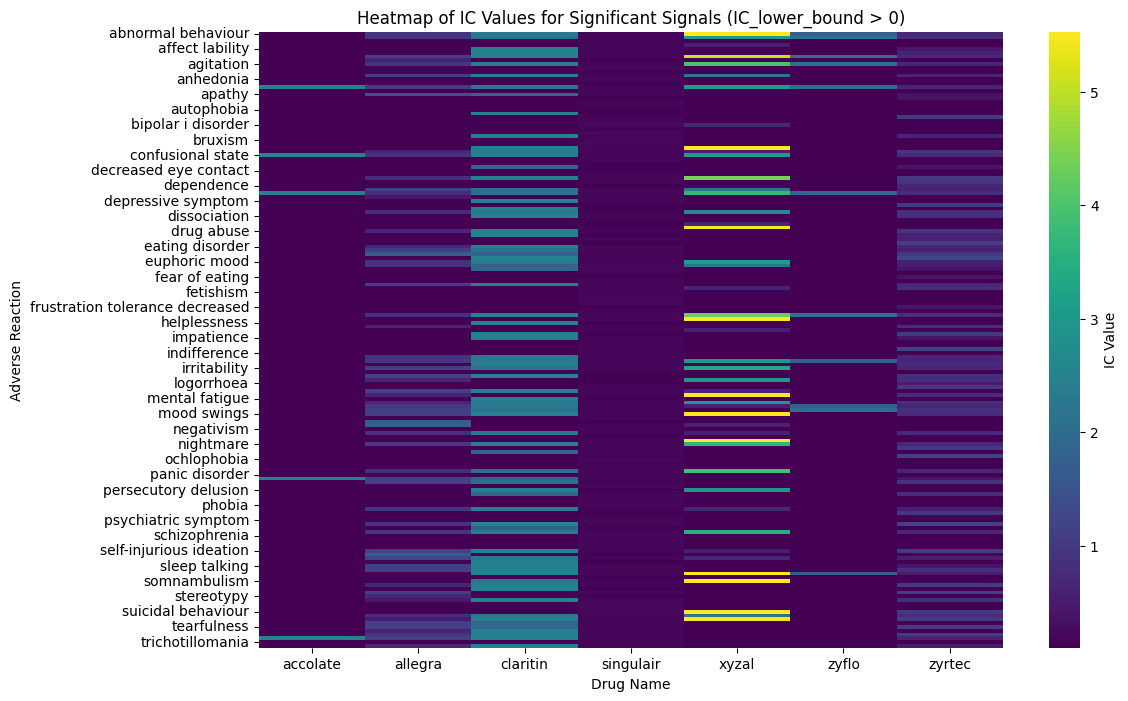

In [72]:
#Since a signal is defined as values that are greater than 0, find those rows
signals_df = df_reaction_and_IC[(df_reaction_and_IC['IC_lower_bound'] > 0)]
#Get counts by the drug name
signal_counts_per_drug = signals_df['ps_drugname'].value_counts()
#Make a table of the counts
print("Signal Counts Per Drug:")
print(tabulate(signal_counts_per_drug.to_frame(), headers=['Drug Name', 'Count'], tablefmt='fancy_grid'))

signal_counts_per_reaction = signals_df['reaction_pt'].value_counts()
print("\nSignal Counts Per Reaction:")
print(tabulate(signal_counts_per_reaction.to_frame(), headers=['Adverse Reaction', 'Count'], tablefmt='fancy_grid'))

#Pivot the signals_df to make a heatmap
signal_pivot = signals_df.pivot_table(index='reaction_pt', columns='ps_drugname', values='IC', fill_value=0.1)

plt.figure(figsize=(12, 8))
plt.title("Heatmap of IC Values for Significant Signals (IC_lower_bound > 0)")
#log norm for color contrast
sns.heatmap(signal_pivot, cmap="viridis", annot=False, fmt=".2f", cbar_kws={'label': 'IC Value'})
plt.xlabel("Drug Name")
plt.ylabel("Adverse Reaction")
plt.show()


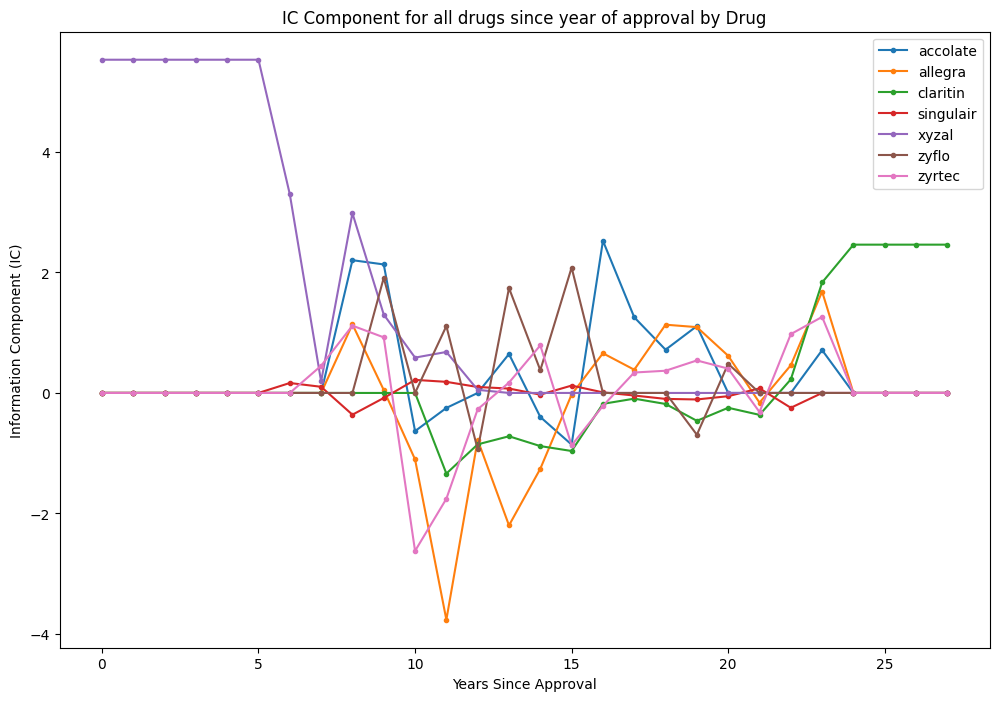

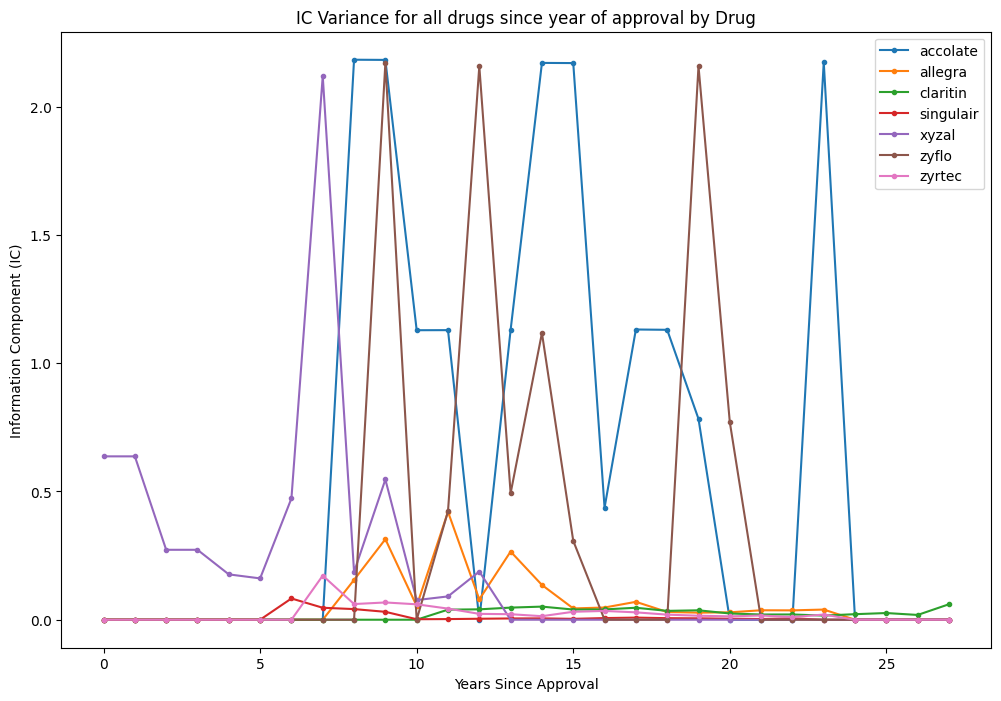

In [73]:
def plot_IC(df, title):
    plt.figure(figsize=(12, 8))

    for drug in df.index:
        #Find data by locating the drug in the index and getting all of the rows and transposing it
        data = pd.DataFrame(df.loc[drug, :]).transpose()

        #Plot the data
        plt.plot(data.columns, data.values[0], marker='.', label=drug)
        # Add labels and legend
        plt.xlabel('Years Since Approval')
        plt.ylabel('Information Component (IC)')
        plt.title(f'{title} by Drug')
        plt.legend()

plot_IC(IC_df, 'IC Component for all drugs since year of approval')

all_signals_df = df_reaction_test.copy()
#Getting the mean ICV across all of the years
mean_IC_years = all_signals_df.groupby(['ps_drugname', 'years_since_approval'])['ICV'].mean().unstack().fillna(0)
plot_IC(mean_IC_years, 'IC Variance for all drugs since year of approval')

	- posterior: given a drug and a reaction, what is the probability of a boxed warning occurring, p(b | d, a), where b is between 0 and 1
	- prior: need 3 priors, p(d), p(a) and p(y), so probability of the drug occurring and the probability of belief that adverse reaction will occur 
	- likelihood: L(d,a,y | b)

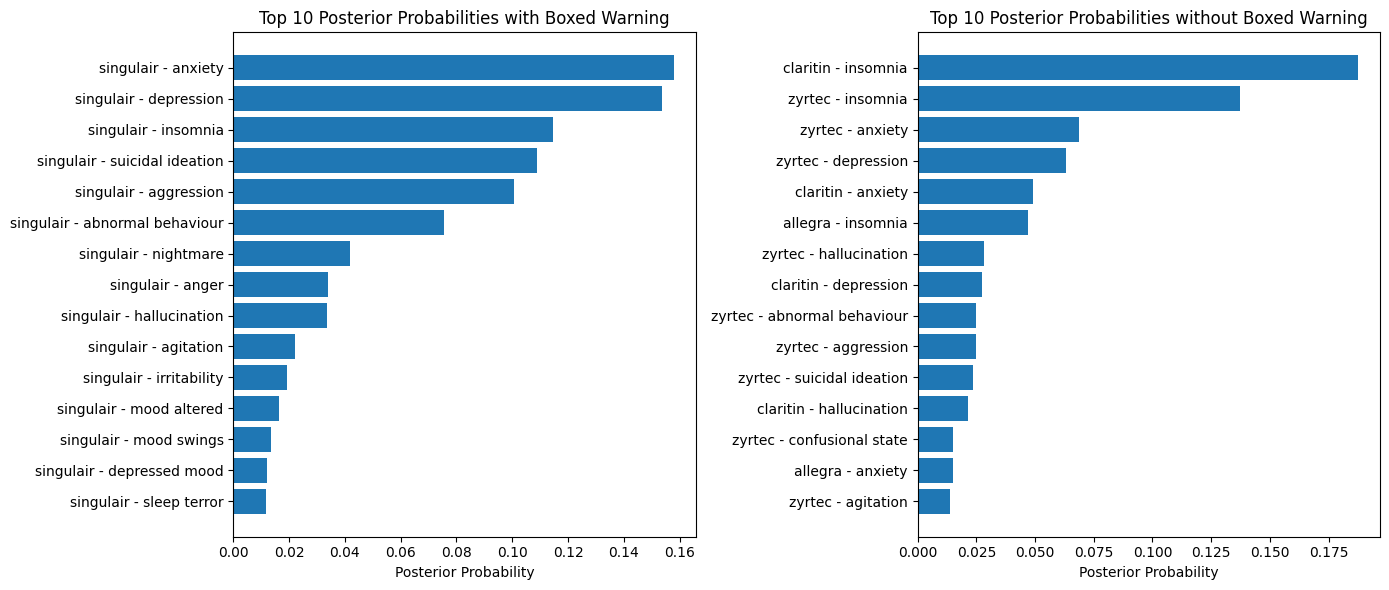

In [74]:
#Regularization parameter to deal with potential reporting bias in Singulair
alpha = 0.5

# Calculate the prior probability for each drug (P(d))
drug_counts = df_reaction_test['ps_drugname'].value_counts() + alpha
total_drugs = len(df_reaction_test['ps_drugname'])
p_d = drug_counts / total_drugs

# Calculate the prior probability for each adverse reaction (P(a))
adverse_counts = df_reaction_test['reaction_pt'].value_counts() + alpha
total_adverse = len(df_reaction_test['reaction_pt'].dropna())
p_a = adverse_counts / total_adverse

#prior for years since approval
# years_since_approval_counts = df_reaction_test['years_since_approval'].value_counts() + alpha
# total_years_since_approval = len(df_reaction_test['years_since_approval'])
# p_y = years_since_approval_counts / total_years_since_approval

# Split the data based on the got_warning status
data_with_warning = df_reaction_test[df_reaction_test['got_warning'] == 1]
data_without_warning = df_reaction_test[df_reaction_test['got_warning'] == 0]

# Calculate the frequency of each (drug, reaction) pair for both groups
count_with_warning = data_with_warning.groupby(['ps_drugname', 'reaction_pt']).size()
count_without_warning = data_without_warning.groupby(['ps_drugname', 'reaction_pt']).size()

# Normalize to get probabilities
total_with_warning = len(data_with_warning)
total_without_warning = len(data_without_warning)

likelihood_with_warning = count_with_warning / total_with_warning
likelihood_without_warning = count_without_warning / total_without_warning

# Calculate the posterior probability using Bayes' theorem
# Posterior P(b | d, a) = (Likelihood * Prior) / Evidence
# We need to calculate this for both cases: with and without warning

# Extract priors for drugs and adverse reactions
p_d_dict = p_d.to_dict()
p_a_dict = p_a.to_dict()
#p_y_dict = p_y.to_dict()


# Calculate the evidence P(d, a) for normalization
# This is the sum of the likelihoods weighted by the priors
evidence_with_warning = sum(likelihood_with_warning * 
                            [p_d_dict.get(d, 0) * p_a_dict.get(a, 0)
                             for d, a in likelihood_with_warning.index])
evidence_without_warning = sum(likelihood_without_warning * 
                               [p_d_dict.get(d, 0) * p_a_dict.get(a, 0)
                                for d, a in likelihood_without_warning.index])

# Calculate the posteriors
posterior_with_warning = (likelihood_with_warning * 
                          [p_d_dict.get(d, 0) * p_a_dict.get(a, 0)
                           for d, a in likelihood_with_warning.index]) / evidence_with_warning
posterior_without_warning = (likelihood_without_warning * 
                             [p_d_dict.get(d, 0) * p_a_dict.get(a, 0)
                              for d, a in likelihood_without_warning.index]) / evidence_without_warning

#Display the posteriors
#posterior_with_warning, posterior_without_warning

top_with_warning = posterior_with_warning.sort_values(ascending=False).head(15)
top_without_warning = posterior_without_warning.sort_values(ascending=False).head(15)

# Combine the MultiIndex into a single string for easier plotting
top_with_warning.index = top_with_warning.index.map(lambda x: f"{x[0]} - {x[1]}")
top_without_warning.index = top_without_warning.index.map(lambda x: f"{x[0]} - {x[1]}")


# Create bar plots again
plt.figure(figsize=(14, 6))

# Plot for posteriors with warning
plt.subplot(1, 2, 1)
plt.barh(top_with_warning.index, top_with_warning.values, align='center')
plt.xlabel('Posterior Probability')
plt.title('Top 10 Posterior Probabilities with Boxed Warning')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest probabilities at the top

# Plot for posteriors without warning
plt.subplot(1, 2, 2)
plt.barh(top_without_warning.index, top_without_warning.values, align='center')
plt.xlabel('Posterior Probability')
plt.title('Top 10 Posterior Probabilities without Boxed Warning')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



In [75]:
#reset index here because if in same cell and rnu multiple times, it will throw an error
posterior_with_warning = posterior_with_warning.reset_index()
posterior_without_warning = posterior_without_warning.reset_index()

In [76]:
# First, let's address the column renaming issue for `posterior_with_warning` and `posterior_without_warning`.
# Since these are Series objects, they don't have a `.columns` attribute. We'll convert them to DataFrames first.

# Convert Series to DataFrame and rename columns
#'Years Since Approval' could be added but still deciding
posterior_with_warning.columns = ['Drug Reaction', 'Reaction', 'Posterior Probability'
                                  ]
#'Years Since Approval' could be added but still deciding
posterior_without_warning.columns = ['Drug Reaction', 'Reaction', 'Posterior Probability']

# Now, find the chronological sequence of suicide events
s_events = ['suicidal behaviour', 'suicidal ideation', 'suicide attempt', 'suspected suicide', 'completed suicide']

# Filter for suicide events in both dataframes
suicide_events_with_warning = posterior_with_warning[posterior_with_warning['Reaction'].str.contains(
    '|'.join(s_events), case=False, na=False)]


suicide_events_without_warning = posterior_without_warning[posterior_without_warning['Reaction'].str.contains(
    '|'.join(s_events), case=False, na=False)]

# Create a 'Pair' column for easy labeling in the plots
suicide_events_with_warning['Pair'] = suicide_events_with_warning['Drug Reaction'] + ' - ' + suicide_events_with_warning['Reaction'] #+ ' - ' + str(suicide_events_with_warning['Years Since Approval'])
suicide_events_without_warning['Pair'] = suicide_events_without_warning['Drug Reaction'] + ' - ' + suicide_events_without_warning['Reaction'] # + ' - ' + str(suicide_events_without_warning['Years Since Approval'])

# Sort both dataframes by Posterior Probability in descending order
sorted_suicide_events_with_warning = suicide_events_with_warning.sort_values(by='Posterior Probability', ascending=False)
sorted_suicide_events_without_warning = suicide_events_without_warning.sort_values(by='Posterior Probability', ascending=False)


def comparing(df1, df2, s_events):
    
    #Group the data that doesnt have the suicide warning by drug reaction
    grouped = df2.groupby('Drug Reaction')
    #Get the keys
    keys = grouped.groups.keys()
    
    #Iterate through the keys
    for key in keys:

        #Get the grouped data for the suicide events without the warning for each drug
        data = grouped.get_group(key)
        
        # If the data does not contain one of the s_events, add a row with Posterior Probability set to zero
        for event in s_events:
            if not data['Reaction'].str.contains(event, case=False, na=False).any():
                # Create a new row with Posterior Probability = 0
                new_row = {'Drug Reaction': key, 'Reaction': event, 'Posterior Probability': 0, 'Pair': f"{key} - {event}"}
                data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)
            if not df1['Reaction'].str.contains(event, case=False, na=False).any():
                new_row = {'Drug Reaction': 'singulair', 'Reaction': event, 'Posterior Probability': 0, 'Pair': f"{key} - {event}"}
                df1 = pd.concat([df1, pd.DataFrame([new_row])], ignore_index=True)

        # Plot suicide events
        plt.figure(figsize=(14, 6))

        # Plot for posteriors with warning
        plt.subplot(1, 2, 1)
        plt.barh(df1['Pair'], df1['Posterior Probability'], align='center')
        plt.xlabel('Posterior Probability')
        plt.title('Posterior Probability for Suicidal Sequences with Boxed Warning')
        plt.gca().invert_yaxis()

        # Plot for posteriors without warning
        plt.subplot(1, 2, 2)
        plt.barh(data['Pair'], data['Posterior Probability'], align='center')
        plt.xlabel('Posterior Probability')
        plt.title('Posterior Probabilities for Suicidal Sequences without Boxed Warning')
        plt.gca().invert_yaxis()

        plt.tight_layout()
        plt.show()



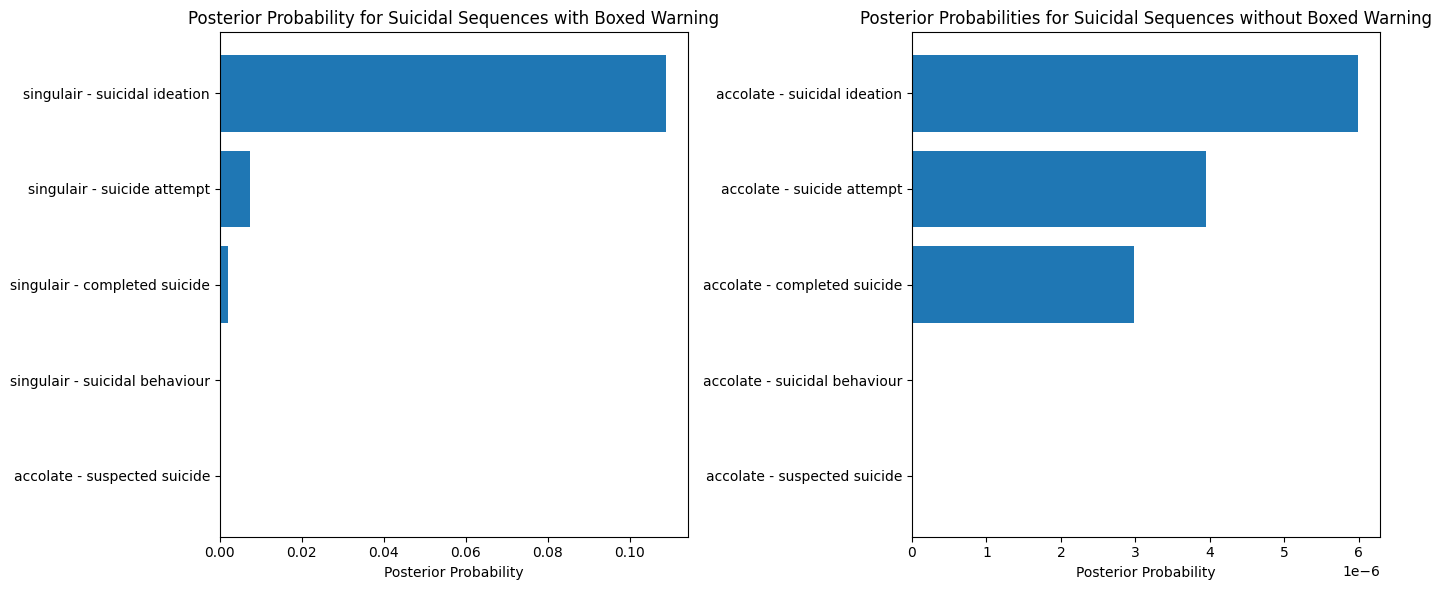

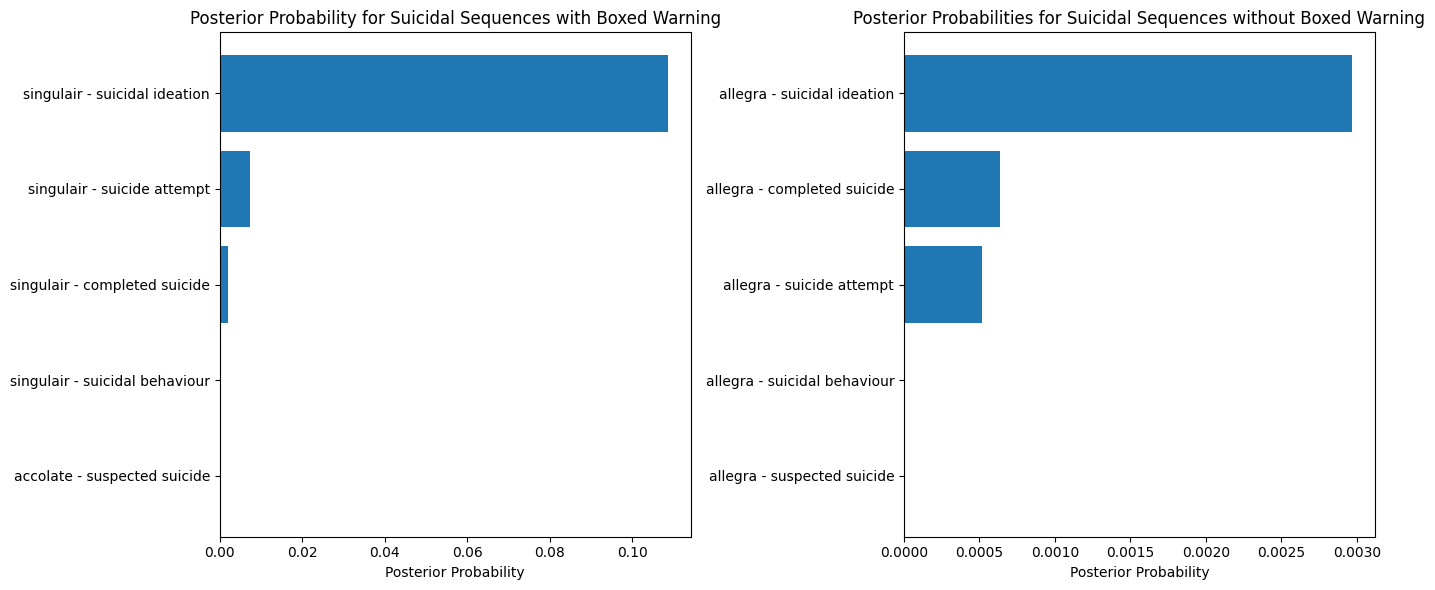

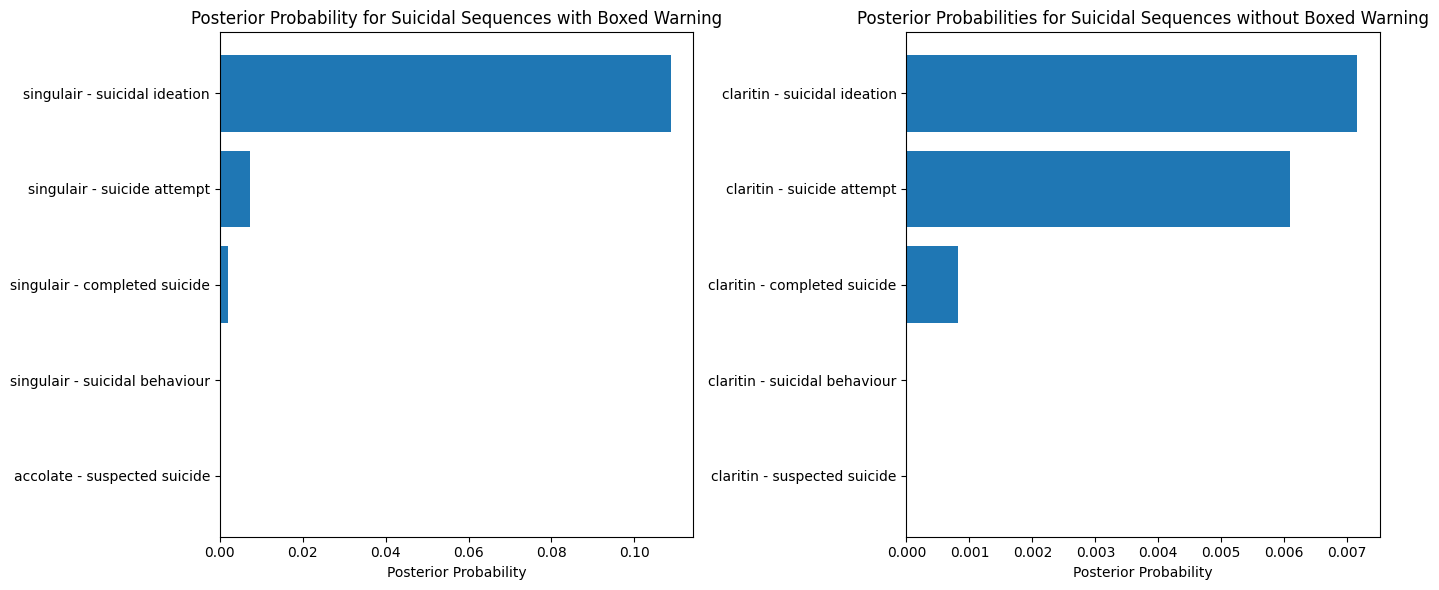

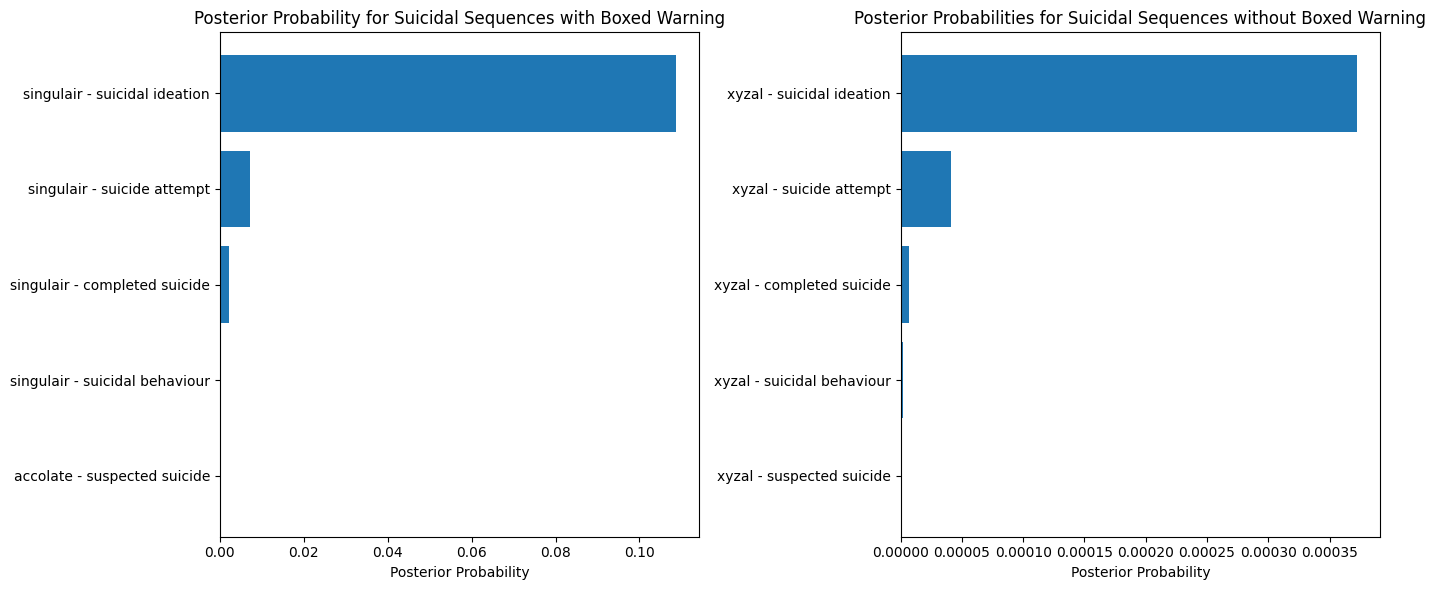

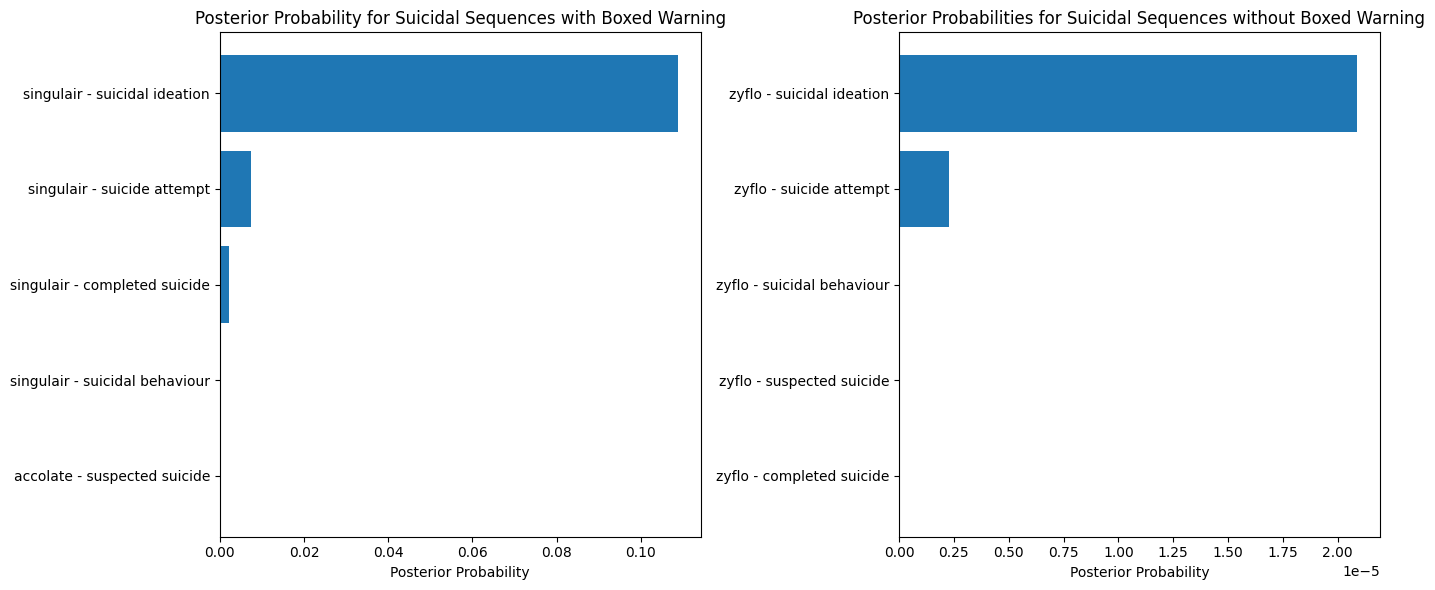

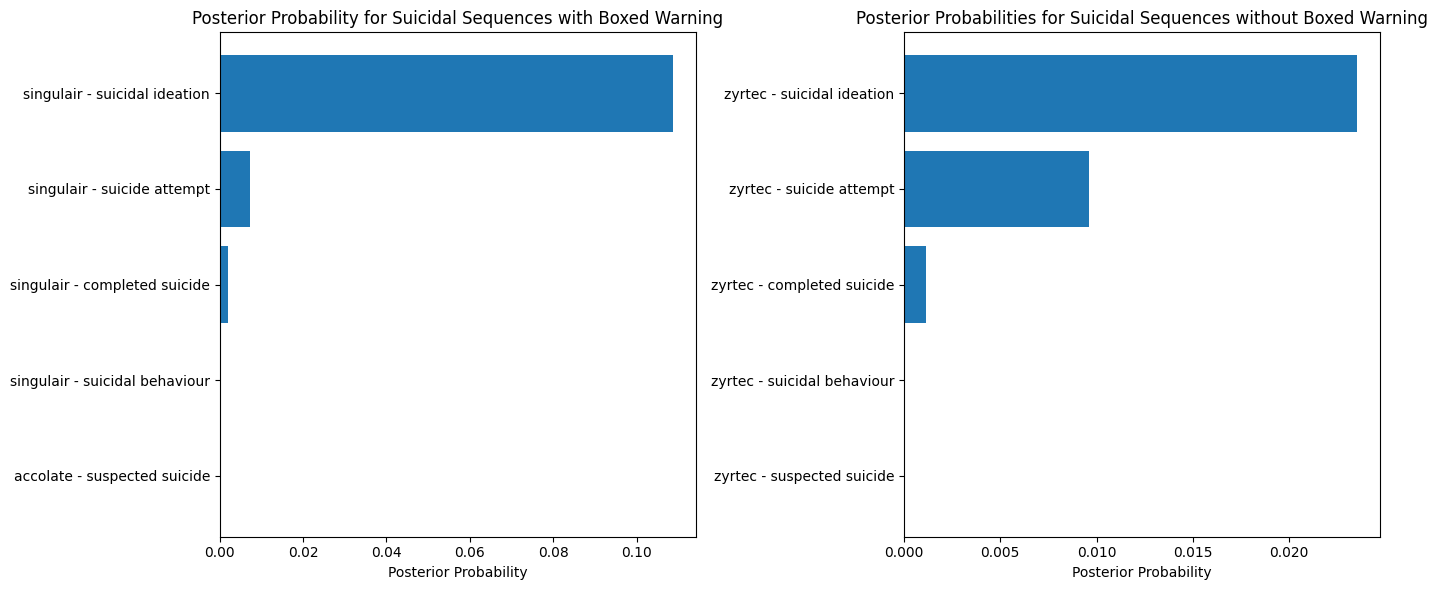

In [77]:
comparing(sorted_suicide_events_with_warning, sorted_suicide_events_without_warning, s_events)

Looking at the graphs of patient outcomes (don't know if anything useful is down below here.)!!!

In [78]:
#Find rows where the reaction is completed suicide
s_conditions = ['completed suicide']
df_s = df_reaction_test[df_reaction_test['reaction_pt'].isin(s_conditions)]
df_s

,caseid,ps_drugname,ps_indi_pt,ss_drugname,ss_indi_pt,c_i_drugname,c_i_indi_pt,reaction_pt,age,age_cod,...,allergy_medication,approval_date,days_since_approval,years_since_approval,got_warning,lag,year,IC,ICV,IC_lower_bound
327,4145233,zyrtec,NaN,cetirizine hcl;meloxicam (meloxicam),NaN,NaN,NaN,completed suicide,58.0,YR,...,ZYRTEC,1996-09-27,2789,8.0,0,188.0,2004,1.116713,0.061062,0.622499
765,5689337,zyrtec,RHINITIS ALLERGIC,cetirizine hcl,RHINITIS ALLERGIC,NaN,NaN,completed suicide,18.0,YR,...,ZYRTEC,1996-09-27,2996,8.0,0,589.0,2004,1.116713,0.061062,0.622499
1452,5890074,zyrtec,ILL-DEFINED DISORDER,clonidine;methotrexate,ILL-DEFINED DISORDER,NaN,NaN,completed suicide,73.0,YR,...,ZYRTEC,1996-09-27,3286,9.0,0,634.0,2005,0.922608,0.067307,0.403738
1465,5896561,zyrtec,NaN,methotrexate;cetirizine hcl,NaN,NaN,NaN,completed suicide,73.0,YR,...,ZYRTEC,1996-09-27,3293,9.0,0,641.0,2005,0.922608,0.067307,0.403738
2274,6184218,allegra,NaN,meloxicam;fexofenadine hcl,NaN,NaN,NaN,completed suicide,42.0,YR,...,ALLEGRA,1996-07-25,3774,10.0,0,692.0,2006,-1.103339,0.053616,-1.566443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43075,14699502,singulair,Asthma,NaN,NaN,ALBUTEROL INHALER;LORATIDINE;TYLENOL,NaN,completed suicide,18.0,YR,...,SINGULAIR,1998-02-20,7342,20.0,1,327.0,2018,-0.053665,0.003933,-0.179098
43235,14716780,singulair,Rhinitis allergic,singulair,Hypersensitivity,NaN,NaN,completed suicide,63.0,YR,...,SINGULAIR,1998-02-20,7362,20.0,1,471.0,2018,-0.053665,0.003933,-0.179098
43976,14934244,singulair,Multiple allergies,oseltamivir phos,Influenza,SINGULAIR;TAMIFLU;TYLENOL,NaN,completed suicide,22.0,YR,...,SINGULAIR,1998-02-20,7379,20.0,1,422.0,2018,-0.053665,0.003933,-0.179098
46630,15538074,claritin,NaN,trimebutine maleate;desloratadine.;paroxetine....,NaN,NaN,NaN,completed suicide,37.0,YR,...,CLARITIN,1993-04-12,9327,26.0,0,78.0,2018,2.461046,0.018626,2.188095


In [79]:

def severity(df):
    #Look at the patient outcomes for the target drugs
    df_outcome = df.copy()


    #Need to explode the outcome column
    df_outcome = df_outcome.assign(reaction_pt=df_outcome['reaction_pt'].str.split(';')).explode('reaction_pt')
    df_outcome = df_outcome.assign(reaction_pt=df_outcome['reaction_pt'].str.split(',')).explode('reaction_pt')
    df_outcome = df_outcome.assign(outc_cod=df_outcome['outc_cod'].str.split(';')).explode('outc_cod')
    df_outcome['reaction_pt'] = df_outcome['reaction_pt'].str.strip().str.lower()

    #Make it such that each outc_cod is represented by a number
    outc_cod_dict = {
        'DE': 7, 
        'LT' : 6,
        'HO' : 4,
        'DS' : 5,
        'CA' : 3,
        'RI' : 2
    }
    #Apply the dictionary to the outc_cod column
    df_outcome['patient_num_outcome'] = df_outcome['outc_cod'].map(outc_cod_dict)

    #groupby caseid and find the mean of the patient_num_outcome, show all columns from df_outcome
    df_test_outcome = df_outcome.groupby('reaction_pt')['patient_num_outcome'].mean().sort_values(ascending=False).fillna(0)

    #Make the series into a DataFrame
    df_test_outcome = df_test_outcome.to_frame()

    #Reset the index
    df_test_outcome = df_test_outcome.reset_index()

    #Strip whitespace and lowercase the reaction_pt column
    df_test_outcome['reaction_pt'] = df_test_outcome['reaction_pt'].str.strip().str.lower()


    #Find where the reaction_pt in df_outcome is the same as the reaction_pt is in the df_test_outcome
    df_outcome = pd.merge(df_outcome, df_test_outcome, on='reaction_pt', how='left')

    #Groupby caseid and find the mean of the patient_num_outcome_y column
    df_caseid_pat = df_outcome.groupby('caseid')['patient_num_outcome_y'].mean()

    #Make the series into a DataFrame
    df_caseid_pat = df_caseid_pat.to_frame()

    #Merge the two DataFrames
    df = pd.merge(df, df_caseid_pat, on='caseid', how='left')

    #Rename the column
    df = df.rename(columns={'patient_num_outcome_y': 'patient_severity'})

    return df

df = severity(df)

In [80]:
#Look at a graph of the patient severity for each of the target drugs
df_severity = df.groupby('ps_drugname')['patient_severity'].mean().sort_values(ascending=False)
df_severity = df_severity.to_frame()
df_severity.columns = ['Severity']
header = ['Drug Name', 'Severity']
print(tabulate(df_severity, headers=header, tablefmt='fancy_grid'))


╒═════════════╤════════════╕
│ Drug Name   │   Severity │
╞═════════════╪════════════╡
│ zyflo       │    4.66982 │
├─────────────┼────────────┤
│ singulair   │    4.62837 │
├─────────────┼────────────┤
│ accolate    │    4.62628 │
├─────────────┼────────────┤
│ zyrtec      │    4.53227 │
├─────────────┼────────────┤
│ allegra     │    4.52345 │
├─────────────┼────────────┤
│ xyzal       │    4.49804 │
├─────────────┼────────────┤
│ claritin    │    4.47008 │
╘═════════════╧════════════╛


<Axes: xlabel='year', ylabel='ps_drugname'>

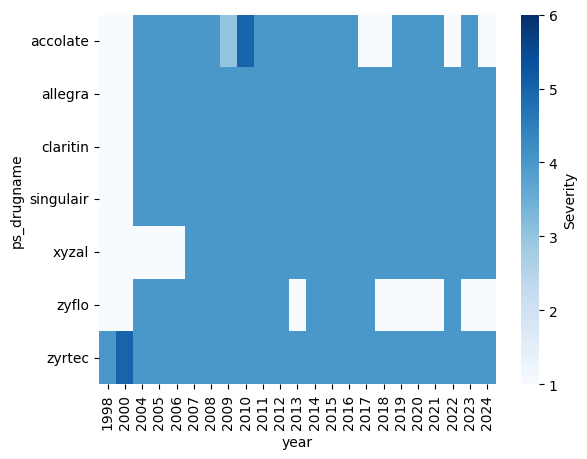

In [81]:
#look at the severity over the years for each drug
df['year'] = df['fda_dt'].dt.year
df_severity_year = df.groupby(['ps_drugname', 'year'])['patient_severity'].mean().sort_values(ascending=False)
df_severity_year = df_severity_year.to_frame()
df_severity_year.columns = ['Severity']
header = ['Drug Name', 'Severity']
#print(tabulate(df_severity_year, headers=header, tablefmt='fancy_grid'))

#Make a heatmap of the severity for each drug over the years
df_severity_year = df_severity_year.unstack().fillna(0)
df_severity_year.columns = df_severity_year.columns.droplevel()
df_severity_year = df_severity_year.astype(int)
sns.heatmap(df_severity_year, cmap='Blues', vmin=1, vmax=df_severity_year.melt(col_level=0).max()['value']+1,
    linecolor='black', cbar_kws={'label': 'Severity'})

Logistic Regression and looking at the odds ratio

In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

#respnose is age column
X = df_reaction_test[['age', 'ps_drugname', 'outc_cod', 'IC', 'ICV', 'IC_lower_bound']]
#Encode the drug names

#Could do one hot encoding on a base model
X = pd.get_dummies(X['ps_drugname'], columns=['ps_drugname'])
y = df_reaction_test['reaction_pt']


model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
model.fit(X, y)

LogisticRegression(random_state=0)

In [83]:
# Extract the coefficients corresponding to drug type
coefficients = model.coef_

# Assuming the drug type is encoded in one of the features
drug_coefficients = coefficients[0]
odds_ratios = np.exp(drug_coefficients)

print(odds_ratios)

[0.67419342 0.50583913 1.10170204 2.09243905 0.63927421 1.34624744
 1.69807408]


In [84]:
#Calculate the pRR for each drug in the odds_ratios
prr_ratios = []
for i in odds_ratios:
    if (sum(odds_ratios) - i) == 0:
        prr = 0
    else:
        prr = (i / (sum(odds_ratios) - i))
        prr_ratios.append(prr)

print(prr_ratios)

[0.09130987736971909, 0.06698143589291726, 0.15838001379110547, 0.35076667030102454, 0.08617303116180801, 0.20058750471949166, 0.2670055721922562]
